In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML, Image
import nbconvert
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import sys
sys.path.insert(0, '../src/visualization')
import visualize 
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

<h1 align="center">Genetic Overlap between Alzheimer's, Parkinson’s, and healthy patients</h1>
<h2 align="center">DSC180B, Section B04: Genetics</h2>
<h2 align="center">Justin Lu, Saroop Samra, Xuanyu Wu
</h2>

## Background

This study aims to find gene expression similarities and differences between patients of Alzheimer's (AD) and Parkinson's (PD). The study uses sequencing data from microRNA (abbreviated miRNA) found in two the body's biofluids, cerebrospinal fluid (CSF) and blood serum (SER). Although these disorders are experienced by many people, little is known about what specifically causes the two diseases and how to prevent or cure them. The difficulty in finding these solutions arises from the complexity of the "pathomechanisms" underlying the diseases, as well as their tendencies to have early stages that are asymptomatic, making detection very challenging until symptoms set in [1]. 

This is where our study comes into play. With our analysis, we aim to study the genetic causes underlying the two diseases by inspecting the sequencing data found in patients' bodies in the form of miRNA sequences. Uncovering the genetics behind the diseases can help researchers better their understanding of the development of AD and PD in humans and improve their chances of finding efficient preventative measures for the two disorders. Furthermore, the similarities that we may find between the disorders can aid in the research of neural disorders in general, and contribute to early diagnosis, prevention, and cures.


## Psychiatric Disorders

### Alzheimer's

Alzheimer's disease is a progressive brain disorder that heavily impacts brain function in that it slowly deteriorates memory and thinking skills, leading to symptoms like forgetting recent events or conversations, to eventually losing the ability to carry out simple tasks or even recognize friends and family members. Difficulty in reasoning and thinking is also a common symptom, especially with abstract concepts like numbers, again making everyday tasks like paying bills challenging. AD also impairs people's abilities to make decisions in everyday situations, like driving. The principal risk factor of Alzheimer's is age; people become more likely to to develop AD as they grow older. Family history can also increase a person's chances of developing the disease. A genetic link to increased chance of AD shows in the form of a variation of the gene APOE e4, something we will definitely explore further in our study. As of now, there is no known cure for AD, but medications have been known to improve or slow the effect of the disease, and programs and caregivers help to support AD patients. [2]


### Parkinson's

Parkinson's disease is a progress nervous system disorder that impacts movement. There are a myriad of symptoms that constitute PD, including a tremor (trembling) in a limb like a hand or fingers, slowed movement, rigid muscles, and impaired posture and balance. PD is also sometimes accompanies by other complications, like cognitive issues (trouble thinking, dementia), emotional changes (like depression), swallowing, chewing, and eating problems, among others. The principal risk factor of PD is age; PD usually develops in people age 60 or older. Other risk factors include family history and sex (men are more likely to develop it than women). As of now, there are no known cures or even prevention methods for Parkinson's. However, there are medications that can ease the symptoms, as well as surgeries that can regulate parts of the brain to improve symptoms. [3]



## miRNA and CSF/SER
Our sequence data comes from the encodings of microRNA strands. microRNA (miRNA) are a class of non-coding RNAs that regulate gene expression. Specifically, they bind to specific mRNA and prevent those target mRNA from translating the necessary directions to produce certain proteins. Because of the behavior of miRNA, it will be worthwhile to explore which miRNA are binding to which mRNA, and subsequently what proteins are being down-regulated (lowly expressed). These proteins could then be contributing factors to the symptoms and/or development of the two diseases. [4]

The miRNA in our study was sourced from two locations (specifically, fluids found in our body): cerebrospinal fluid (CSF) and blood serum (SER). These two fluids are part of the central nervous system, which are highly impacted by both PD and AD. CSF cushions the brain and is a "shock absorber" for the central nervous system, and also removes waste products from the brain [5]. Blood serum (or serum) is the fluid that blood cells move through, but without the plasma - it is the clear liquid that remains after blood clots. [6] miRNA is found in serum as "secreted miRNAs", meaning miRNA that has been excreted from cells or tissues. [7]



## Pipeline

For this project, the basic overview of our pipeline is that we want to access our data, preform necessary quality checks (qc), then merge the inputs into a gene_matrix and feature table, normalize by outputting normalized counts, return the LRT plots in the analysis step, and then finally visualize.

The overall pipeline is shown in Figure 1 below.

In [2]:
figNum = 1
tableNum = 1

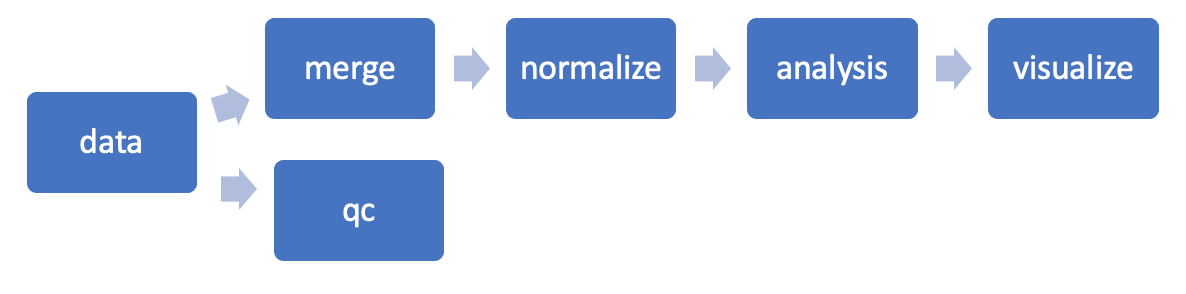

In [3]:
display(Image("basic_pipeline.png", width=800))
display(HTML("<b>Figure "+str(figNum)+": Pipeline Overview</b>"))
figNum += 1

Our original plan was to use STAR or kallisto for alignment and gene counting however we could not get access to the entire dataset and the dataset in the NCBI. Instead we contacted Professor Kendall Jensen, author of the original paper, who shows us the exRNA Atlas is the data repository of the Extracellular RNA Communication Consortium (https://exrna-atlas.org/) which is a repository includes small RNA sequencing and qPCR-derived exRNA profiles from human and mouse biofluids. The study processed dataset was included in this repository including the gene count matrix files for each sample.

The features table is also an input to the data target which is shown below in Table 1. This table was generated from three different sources:

- Atlas core table that held information about the codition and biofluid
- NCBI's SRA Run table that held the age and SRA Run attributes
- The attributes table from the research paper that held many other attributes such as expired age, PMI, plaque density, Braak Score.

These tables were all merged in the data step using Pandas merge feature.

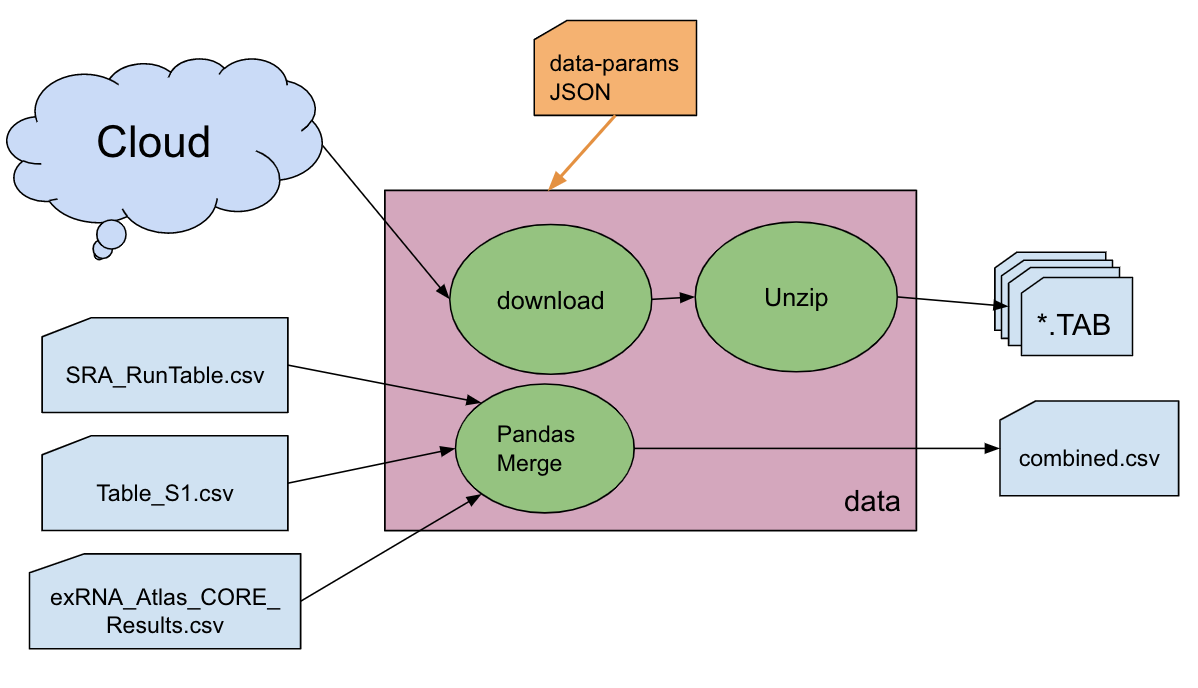

In [4]:
display(Image("data_step.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Data Overview</b>"))
figNum += 1

In [5]:
# explain qc step

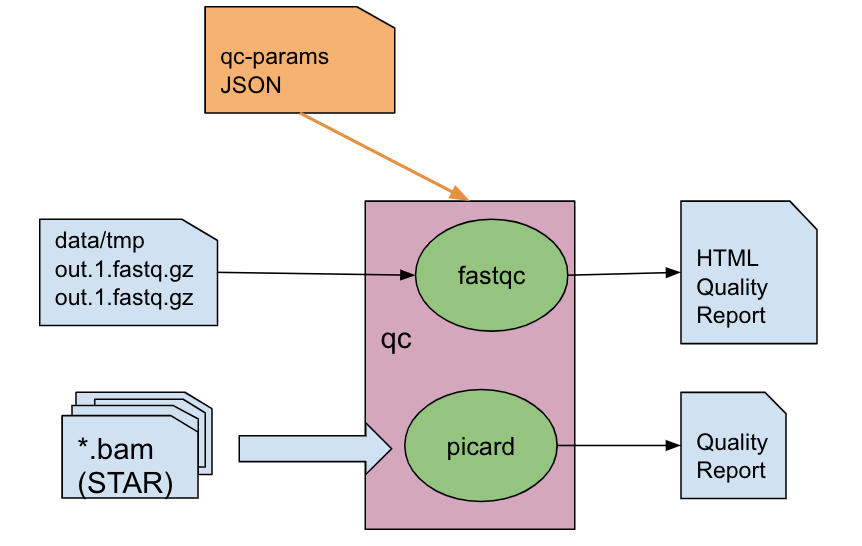

In [6]:
display(Image("qc_step.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": QC Overview</b>"))
figNum += 1

The next step is to execute the "merge" step: which takes all the gene count SRA files and merges them in one gene matrix table using Pandas[<sup>14</sup>](#fn14). The output will also be a gene experiments table which identifies the sample labels and the patient features (age, disorder etc). 

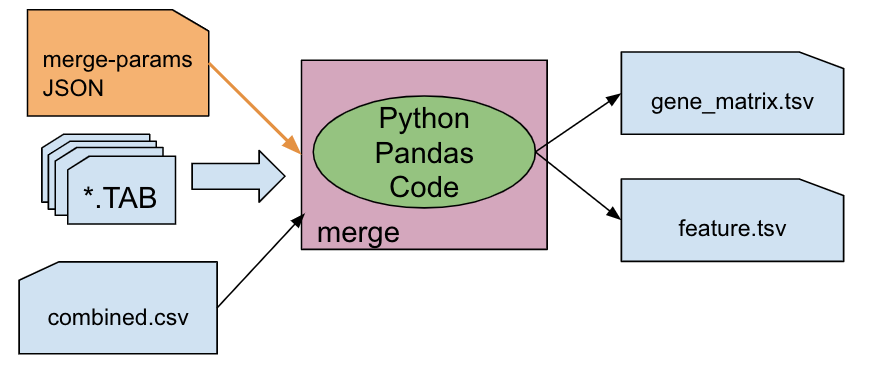

In [7]:
display(Image("merge_step.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Merge Overview</b>"))
figNum += 1

After merging, we execute the "normalize" step: this imports the merged gene count matrix into a custom R script which uses the DESeq2[<sup>15</sup>](#fn15) module to generate two normalized matrix counts: one uses standard normalization and the other Variable Stablization Transformation.

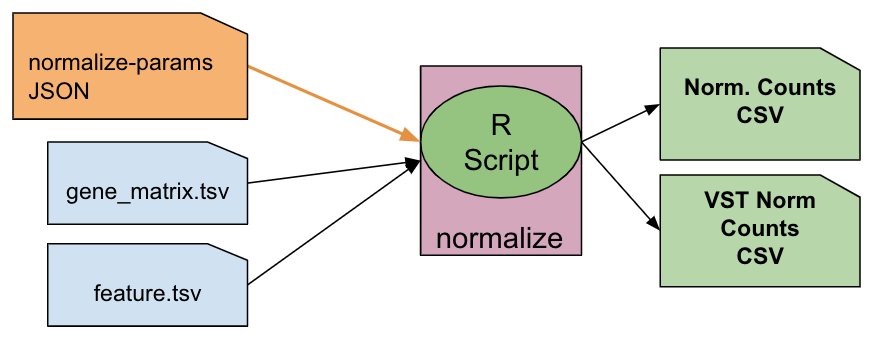

In [8]:
display(Image("normalize_step.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Normalize Overview</b>"))
figNum += 1

After normalizing we execute the "analysis" step: this generates 4 Likelihood Ratio test (LRT), a hypothesis test that compares models in terms of how they fit the available data by comparing the likelihood scores of the models[<sup>9</sup>](#fn9). Each of the 4 LRT's corresponds to a one biofluid and one disorder. The LRT will be compared against that disorder versus the control group. Additionally, an MA Plot and Heatmap are generated.

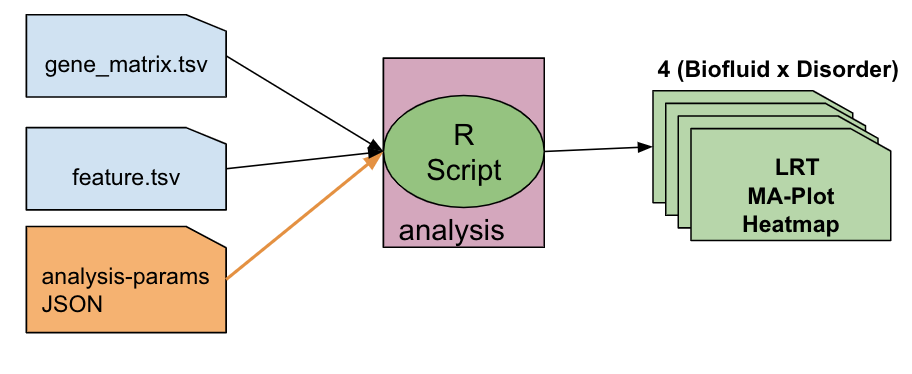

In [9]:
display(Image("analysis_step.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Analysis Overview</b>"))
figNum += 1

<font color="red">explain visualize step</font>

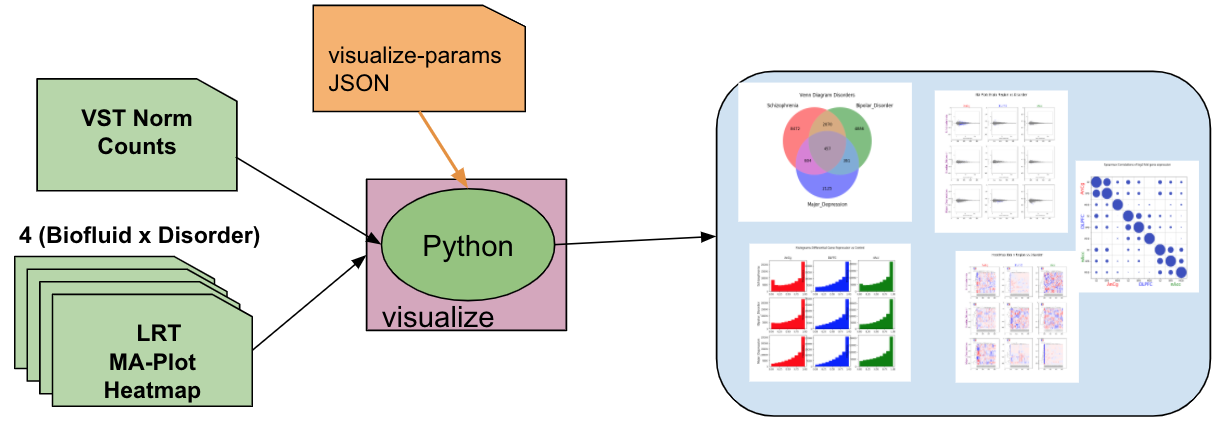

In [10]:
display(Image("visualize_step.png", width=600))
display(HTML("<b>Figure "+str(figNum)+": Visualize Overview</b>"))
figNum += 1

Finally, Figure 8  shows the entire pipeline from start to finish. The merged attributes table is also shown in Table 1 with a subset of the features that was merged from the 3 source tables. The condition column was either Parkinson's, Alzheimer's or a healthy patient. The biofluid column holds the source of where the miRNA samples was taken from, either serum or the cerebrospinal fluid.

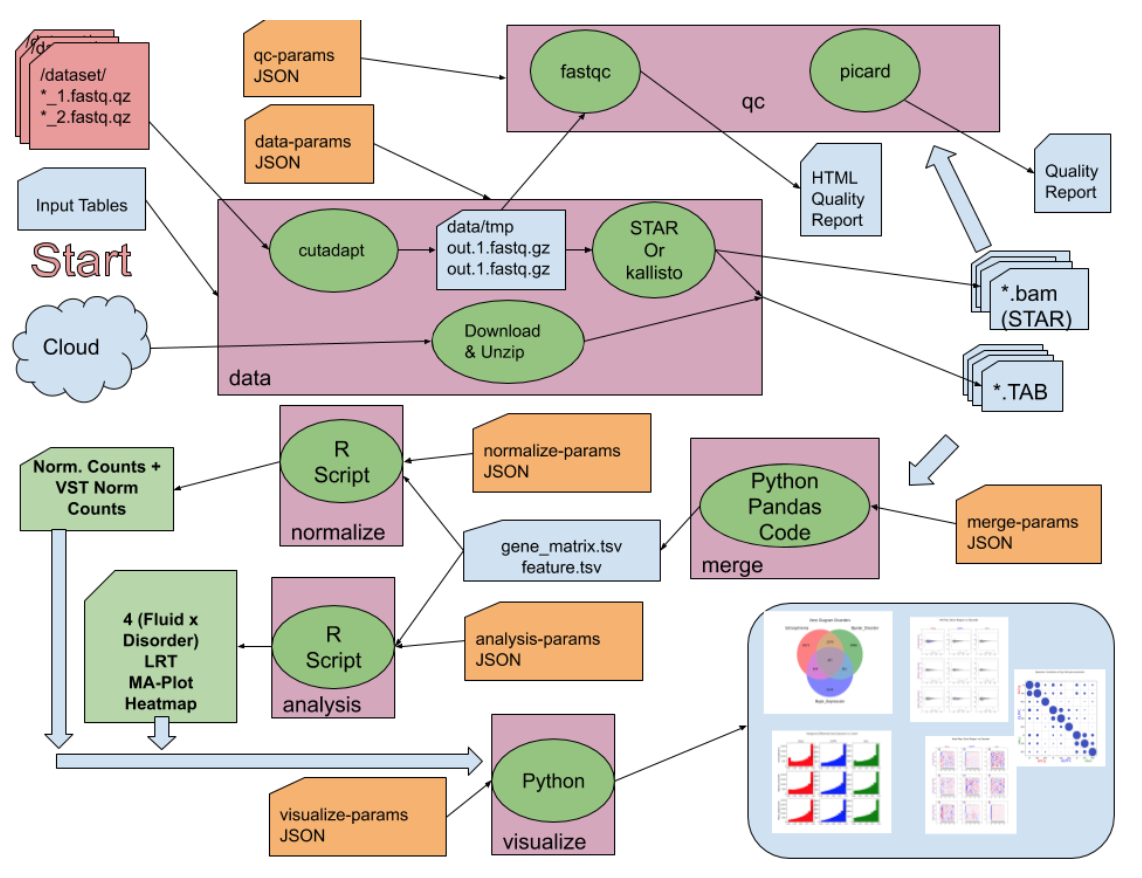

In [11]:
display(Image("pipeline.png", width=600))
display(HTML("<b>Figure "+str(figNum)+": Pipeline Details</b>"))
figNum += 1

In [12]:
df = pd.read_csv("../data/raw/exRNA_Atlas_CORE_Results.csv")
display(df[["Run", "CONDITION", "BIOFLUID", "sex", 'expired_age', 'PMI', 'PlaqueTotal', 'Plaque density', 'TangleTotal',
       'Braak score']])
display(HTML("<b>Table "+str(tableNum)+": Merged Attributes Table</b>"))
tableNum += 1

,Run,CONDITION,BIOFLUID,sex,expired_age,PMI,PlaqueTotal,Plaque density,TangleTotal,Braak score
0,SRR1568567,Healthy Control,Cerebrospinal fluid,male,94,2.50,15.00,frequent,12.00,IV
1,SRR1568730,Parkinson's Disease,Serum,female,79,6.00,2.75,sparse,3.25,II
2,SRR1568666,Alzheimer's Disease,Serum,female,81,2.50,11.50,frequent,11.10,V
3,SRR1568510,Parkinson's Disease,Cerebrospinal fluid,male,79,2.50,7.50,moderate,3.00,II
4,SRR1568518,Parkinson's Disease,Cerebrospinal fluid,female,82,4.16,0.00,zero,6.50,III
...,...,...,...,...,...,...,...,...,...,...
338,SRR1568457,Parkinson's Disease,Cerebrospinal fluid,female,79,3.50,13.25,moderate,6.50,IV
339,SRR1568654,Healthy Control,Serum,male,84,2.66,7.00,sparse,4.00,III
340,SRR1568729,Parkinson's Disease,Cerebrospinal fluid,female,79,6.00,2.75,sparse,3.25,II
341,SRR1568430,Parkinson's Disease,Cerebrospinal fluid,male,79,4.50,0.25,zero,1.75,II


## Quality Checks

#### Cutadapt

TODO

#### FastQC

FastQC is a tool that is used in checking the quality of raw sequencing data before performing large-scale analysis. The software tool calculates and outputs quality metrics of each of the sequence reads, which allows us to determine whether to keep a sequence read, to “cut away” the extraneous parts of a sequence (using cutadapt), or to leave out the read altogether. The metrics (shown as graphs and tables) include “Per sequence quality scores”, which indicates the average quality of reads over the sequences of an SRA run, “Sequence length distribution”, the distribution of sequence lengths, and an important factor, “Overrepresented sequences”, which are sequences that are not found to be in the human genome, among other measurements. Specifically for overrepresented sequences, FastQC marks these as “overrepresented” because it cannot find the source of the sequences; however, more often than not, they are adapters that have been “tacked on” during the library preparation of the sequences, and are then caught by FastQC. This is where we would use the cutadapt tool to cut out those unnecessary sections, or just completely leave the reads out of the analysis. In the end, by combining all these factors, our decision to keep or leave out sequence reads follows the ERCC Quality Control Standards. These standards for our data (which is specifically an exRNA-seq dataset) were drawn up at a Washington, DC conference in November 2015 in order to have a universal set of quality check guidelines [8]: 
1.	An individual RNA-Seq dataset is required to have a minimum of 100,000 reads that overlap (sense or antisense) with any annotated RNA transcript in the host genome. The annotation includes all small RNAs, such as miRNAs (from miRBase), piRNAs, tRNAs, snoRNAs, and circular RNAs, as well as long transcripts from GENCODE, which includes both protein coding genes and long non-coding RNAs (lncRNAs).
2.	The fraction of reads that align to the host genome (after filtering out contaminants, adaptor dimers and ribosomal reads) that also align to any annotated RNA transcript (described in point #1) should be greater than 0.5.

Below, we compare some of the FastQC outputs for reads that were marked as "Pass" versus those marked as "Fail".

#### Data Specificity

TODO






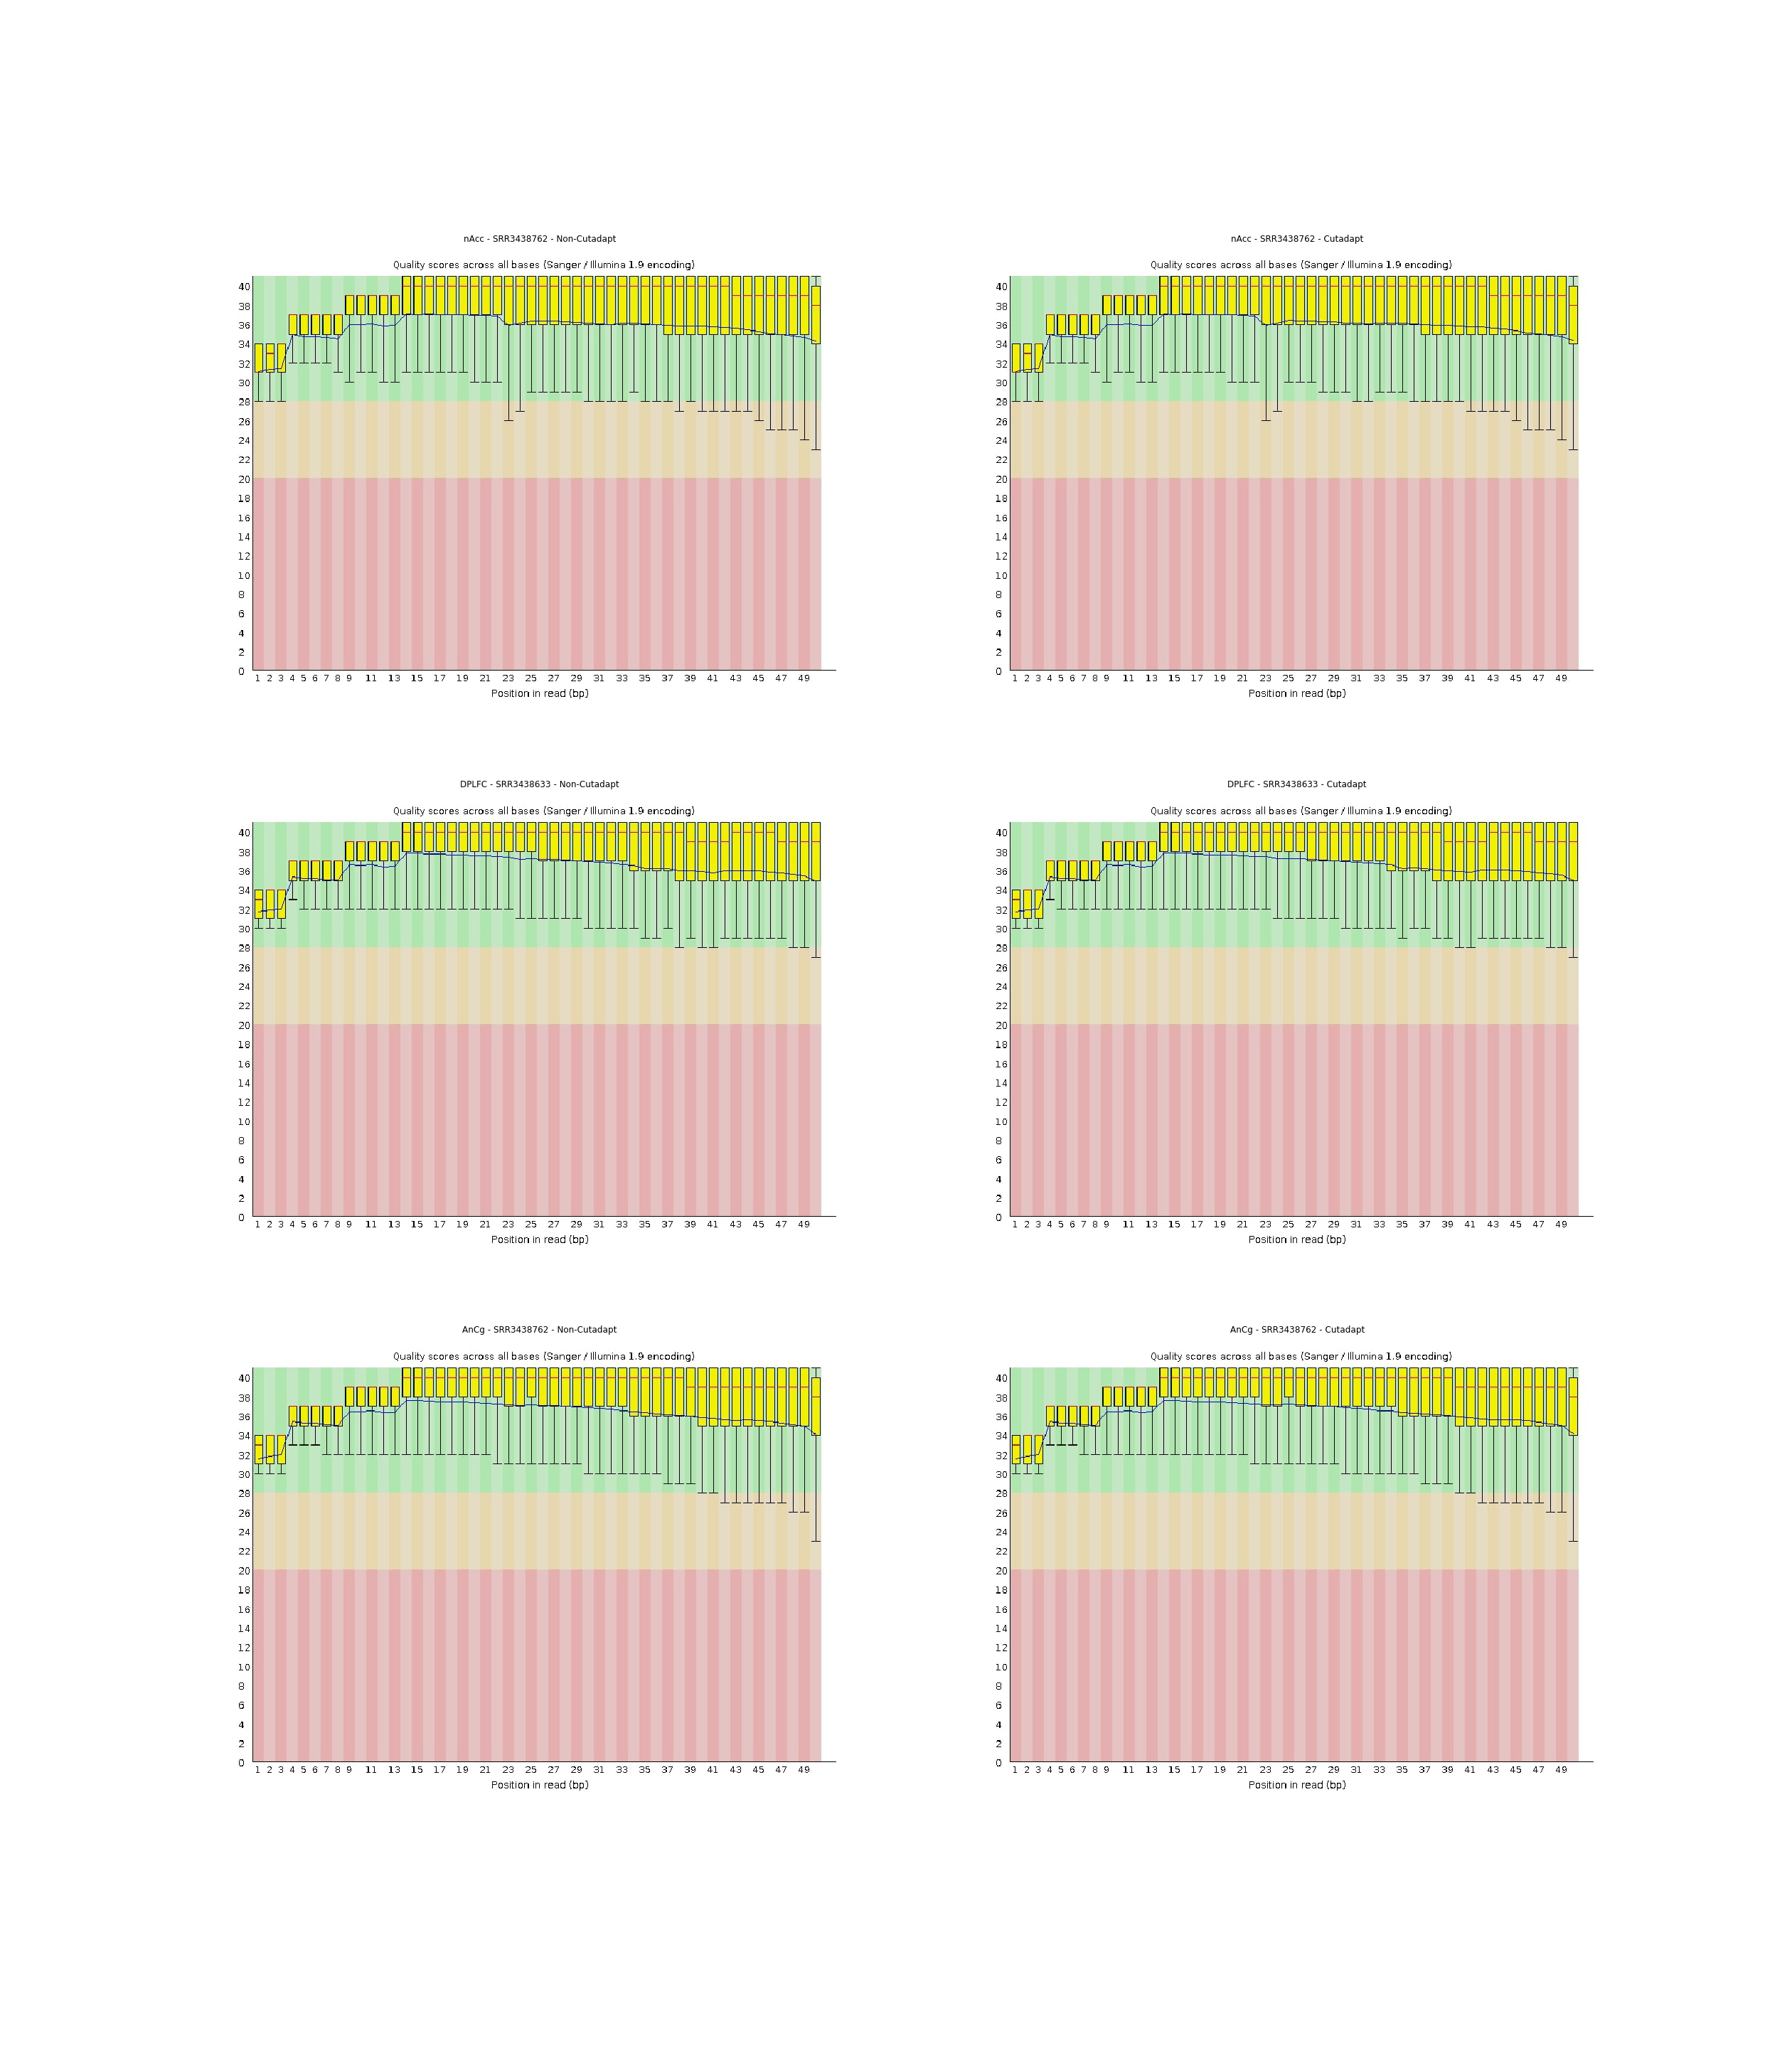

In [13]:
# TODO
display(Image("cutadapt.png", width=800))
display(HTML("<b>Figure "+str(figNum)+": Cutadapt Visualization</b>"))
figNum += 1

<font color = "red"> Explain whether we decide to do fastqc/cutadapt or not</font>

## EDA

### Experiments Features Table

<font color="red">Explain each of the variables used (e.g. "Run", "CONDITION", "BIOFLUID", "sex", 'expired_age', 'PMI', 'PlaqueTotal', 'Plaque density', 'TangleTotal',
       'Braak score') </font>

In [14]:
sra_data = pd.read_csv("../data/raw/exRNA_Atlas_CORE_Results.csv", index_col=0)

display(sra_data[["Run", "CONDITION", "BIOFLUID", "sex", 'expired_age', 'PMI', 'PlaqueTotal', 'Plaque density', 'TangleTotal', 'Braak score']])
display(HTML("<b>Table "+str(tableNum)+": Feature attributes</b>"))
tableNum += 1

,Run,CONDITION,BIOFLUID,sex,expired_age,PMI,PlaqueTotal,Plaque density,TangleTotal,Braak score
0,SRR1568567,Healthy Control,Cerebrospinal fluid,male,94,2.50,15.00,frequent,12.00,IV
1,SRR1568730,Parkinson's Disease,Serum,female,79,6.00,2.75,sparse,3.25,II
2,SRR1568666,Alzheimer's Disease,Serum,female,81,2.50,11.50,frequent,11.10,V
3,SRR1568510,Parkinson's Disease,Cerebrospinal fluid,male,79,2.50,7.50,moderate,3.00,II
4,SRR1568518,Parkinson's Disease,Cerebrospinal fluid,female,82,4.16,0.00,zero,6.50,III
...,...,...,...,...,...,...,...,...,...,...
338,SRR1568457,Parkinson's Disease,Cerebrospinal fluid,female,79,3.50,13.25,moderate,6.50,IV
339,SRR1568654,Healthy Control,Serum,male,84,2.66,7.00,sparse,4.00,III
340,SRR1568729,Parkinson's Disease,Cerebrospinal fluid,female,79,6.00,2.75,sparse,3.25,II
341,SRR1568430,Parkinson's Disease,Cerebrospinal fluid,male,79,4.50,0.25,zero,1.75,II


## General Patient Population

<font color = "red"> We performed EDA on our dataset to get acquire a general sense of the data and its contents. To begin, we first removed several columns that were either unnecessary, contained categorical data, and/or contained repeated values that offered no significance. This modified dataframe, "sra_data", is the dataframe in which the rest of our EDA is based on. Table 2 and Table 3 below describe our dataset as a whole, taking into account both the male and female population. </font>

In [15]:
# General Data Description
display(sra_data[['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal']].describe().round(3))

display(HTML("<b>Table "+str(tableNum)+": Descriptive statistics</b>"))
tableNum += 1

,expired_age,DiseaseDuration,PMI,PlaqueTotal,TangleTotal
count,343.000,218.000,343.000,343.000,341.000
mean,81.006,9.477,3.220,7.947,6.628
std,8.190,6.876,1.559,5.531,4.795
min,38.000,0.000,1.160,0.000,0.000
25%,76.000,5.000,2.415,1.500,3.000
50%,82.000,8.000,2.830,9.000,5.000
75%,87.000,13.000,3.500,13.000,10.500
max,99.000,30.000,12.000,15.000,15.000


In [16]:
# Data Description broken down by Gender and Clinical Diagnosis
gender_info = sra_data.groupby(['sex','CONDITION'])['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal'].mean()
gender_info = gender_info.unstack(level=0)
display(gender_info.round(3))

display(HTML("<b>Table "+str(tableNum)+": Feature attributes Grouped By Gender and Condition</b>"))
tableNum += 1

expired_age         DiseaseDuration            PMI         \
sex                      female    male          female    male female   male   
CONDITION                                                                       
Alzheimer's Disease      80.310  81.788           7.946   6.740  2.894  3.051   
Healthy Control          83.690  80.279           1.333   4.857  3.029  2.879   
Parkinson's Disease      81.535  78.984          14.947  11.049  4.221  3.516   

                    PlaqueTotal         TangleTotal          
sex                      female    male      female    male  
CONDITION                                                    
Alzheimer's Disease      13.197  12.998      12.469  11.581  
Healthy Control           4.846   5.376       3.893   3.748  
Parkinson's Disease       6.285   5.746       5.506   3.758

### TODO - More EDA



## Biofluid Region

During our EDA of the three biofluid regions specified in the replication project, we narrowed our focus on seeing how correlated the two biofluid regions of the study were when it came to the variables <font color="red"> 'age_at_death", "Brain_pH", and "post-mortem_interval". The findings when it came to the anterior cingulate cortex (AnCg) showed it to contain the most correlated values compared to the other two regions. Throughout the remainder of the project, much of the significant conclusions of the project would involve the AnCg.  </font>

#### Mean Break Down of Disorders at Each Biofluid

<font color="red">Explain.</font>

In [17]:
# Averages broken down by source_name
region_info = sra_data.groupby(['CONDITION', 'BIOFLUID'])['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal'].mean()
display(region_info.round(3))
display(HTML("<b>Table "+str(tableNum)+": Numeric feature attributes Grouped By Condition and Biofluid</b>"))
tableNum += 1

expired_age  DiseaseDuration    PMI  \
CONDITION           BIOFLUID                                                   
Alzheimer's Disease Cerebrospinal fluid       81.633            7.569  2.942   
                    Serum                     80.260            7.146  2.999   
Healthy Control     Cerebrospinal fluid       81.984            3.286  3.019   
                    Serum                     81.714            3.167  2.878   
Parkinson's Disease Cerebrospinal fluid       79.895           13.173  3.731   
                    Serum                     80.140           11.851  3.876   

                                         PlaqueTotal  TangleTotal  
CONDITION           BIOFLUID                                       
Alzheimer's Disease Cerebrospinal fluid       13.104       12.078  
                    Serum                     13.102       12.034  
Healthy Control     Cerebrospinal fluid        5.321        3.910  
                    Serum                      4.943        3.720  
Parkinson's Disease Cerebrospinal fluid        5.768        4.535  
                    Serum                      6.185        4.375

#### Correlation Observation of the Serum Biofluid

<font color="red>">Explain</font>

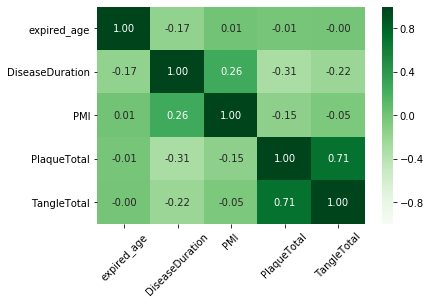

,expired_age,DiseaseDuration,PMI,PlaqueTotal,TangleTotal
expired_age,1.000,-0.170,0.009,-0.012,-0.004
DiseaseDuration,-0.170,1.000,0.259,-0.306,-0.215
PMI,0.009,0.259,1.000,-0.146,-0.047
PlaqueTotal,-0.012,-0.306,-0.146,1.000,0.710
TangleTotal,-0.004,-0.215,-0.047,0.710,1.000


In [18]:
# Serum Correlation Observation
Serum_region = sra_data[['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal']][sra_data['BIOFLUID'].str.contains("Serum")]
Serum_corr_data = Serum_region.corr()
sns.heatmap(Serum_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-1.0, vmax=1.0)
plt.xticks(rotation=45)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()
display(HTML("<b>Figure "+str(figNum)+": Serum Biofluid Heatmap Correlations.</b>"))
figNum += 1

display(Serum_corr_data.round(3))
display(HTML("<b>Table "+str(tableNum)+": Serum Biofluid Correlation Values</b>"))
tableNum += 1

#### Correlation Observation of the Cerebrospinal Biofluid

<font color="red">Explain</font>

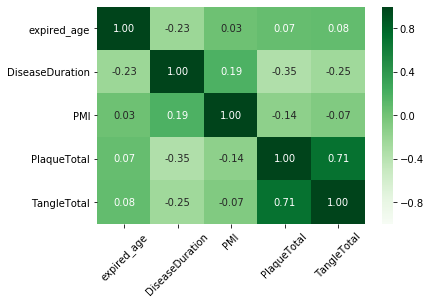

,expired_age,DiseaseDuration,PMI,PlaqueTotal,TangleTotal
expired_age,1.000,-0.226,0.027,0.067,0.083
DiseaseDuration,-0.226,1.000,0.190,-0.349,-0.246
PMI,0.027,0.190,1.000,-0.143,-0.074
PlaqueTotal,0.067,-0.349,-0.143,1.000,0.707
TangleTotal,0.083,-0.246,-0.074,0.707,1.000


In [19]:
# Cerebrospinal fluid Correlation Observation
Cerebrospinal_region = sra_data[['expired_age','DiseaseDuration', 'PMI', 'PlaqueTotal', 'TangleTotal']][sra_data['BIOFLUID'].str.contains("Cerebrospinal fluid")]
Cerebrospinal_corr_data = Cerebrospinal_region.corr()
sns.heatmap(Cerebrospinal_corr_data, annot=True, fmt=".2f", cmap='Greens',vmin=-1.0, vmax=1.0)
plt.xticks(rotation=45)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()
display(HTML("<b>Figure "+str(figNum)+": Cerebrospinal Biofluid Heatmap Correlations.</b>"))
figNum += 1

display(Cerebrospinal_corr_data.round(3))
display(HTML("<b>Table "+str(tableNum)+": Cerebrospinal Biofluid Correlation Values</b>"))
tableNum += 1

## QC Standards

<font color="red">During the EDA we found that 324 of the 342 samples were uniquely assigned to a patient and biofluid region. However, there were 19 failed the ERCC quality control standard. There was an additional sample that was repeated. If we had more time we would have pursued a further analysis on this repeated samples, in particular we would eliminate the repeating samples based on a quality check (e.g. using cutadapt). However, due to lack of time we decided to remove the repeated samples in our analysis.</font>

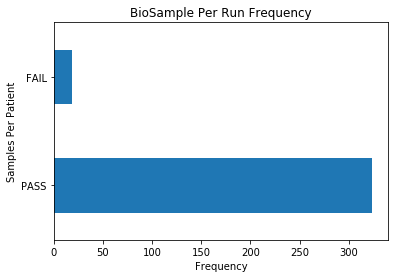

,MEETS ERCC QC STANDARDS?
PASS,324
FAIL,19


In [20]:
ax = sra_data["MEETS ERCC QC STANDARDS?"].value_counts().plot(kind='barh')
ax.set_xlabel("Frequency")
ax = ax.set_ylabel("Samples Per Patient")
plt.title("BioSample Per Run Frequency")
plt.show()
display(HTML("<b>Figure "+str(figNum)+": Pass and Fail SRA Samples.</b>"))
figNum += 1


display(sra_data["MEETS ERCC QC STANDARDS?"].value_counts().to_frame())
display(HTML("<b>Table "+str(tableNum)+": Pass and Fail SRA Samples</b>"))
tableNum += 1

## Processing of Data

### Merging counts

The downloaded file package per sample contained a TSV gene count file. The table has a column that indicates the abundance count. The 322 abundance files were merged into one gene count file. Special care was needed to ensure that the columns and rows matches up - the columns were the SRA runs, and the rows were the gene counts. The output was a table with over 180K genes, however most of the genes had no overlap amonst the SRA samples. After removing null rows, the final gene matrix table had 400+ miRNA.  A portion of the final gene matrix table is shown in Table 8 below. 

In [21]:
df1 = pd.read_csv("../data/out/gene_matrix.tsv", sep='\t', index_col=0)
display(df1.iloc[0:6:,0:6].round(3))
display(HTML("<b>Table "+str(tableNum)+": Subset of the gene matrix showing the first 6 SRA Run's and the first 6 genes.</b>"))
tableNum += 1

,SRR1568624,SRR1568378,SRR1568666,SRR1568746,SRR1568500,SRR1568658
ENST00000362911.1:misc_RNA:Y_RNA.79-201,36.0,4.0,16.0,10.0,38.0,65.0
ENST00000410369.1:misc_RNA:RNY5P8-201,83.0,1.0,12.0,12.0,24.0,73.0
ENST00000538098.2:protein_coding:WDR74-005,337.0,39.0,99.0,33.0,81.0,171.0
ENST00000584923.1:lincRNA:SNORD3A-001,144.0,14.0,110.0,19.0,78.0,163.0
ENST00000517300.1:antisense:7SK.3-001,29.0,12.0,12.0,2.0,10.0,17.0
ENST00000390856.1:snoRNA:SNORD66-201,29.0,3.0,14.0,8.0,19.0,67.0


<span style="color:red"> Another output of the merge step was to generate the feature experiment table. This had the SRA Run's as rows and the pertinent features as columns. As in the research paper we selected the disorder, age, brain region, brain pH and PMI. The feature table, Table 9, is shown below with 350 SRA runs, and the 5 feature labels. </span>

In [22]:
df2 = pd.read_csv("../data/out/features.tsv", sep='\t', index_col=0)
display(df2)
display(HTML("<b>Table "+str(tableNum)+": Feature table which has features we are interested for all the SRA Run's.</b>"))
tableNum += 1

,Disorder,expired_age,Biofluid,sex,PMI,sn_depigmentation,Braak_Score,TangleTotal,Plaque_density,PlaqueTotal
Run,,,,,,,,,,
SRR1568567,Control,94,Cerebrospinal,male,2.50,none,IV,12.00,frequent,15.00
SRR1568730,Parkinson,79,Serum,female,6.00,severe,II,3.25,sparse,2.75
SRR1568666,Alzheimer,81,Serum,female,2.50,mild,V,11.10,frequent,11.50
SRR1568510,Parkinson,79,Cerebrospinal,male,2.50,severe,II,3.00,moderate,7.50
SRR1568518,Parkinson,82,Cerebrospinal,female,4.16,severe,III,6.50,zero,0.00
...,...,...,...,...,...,...,...,...,...,...
SRR1568457,Parkinson,79,Cerebrospinal,female,3.50,severe,IV,6.50,moderate,13.25
SRR1568654,Control,84,Serum,male,2.66,none,III,4.00,sparse,7.00
SRR1568729,Parkinson,79,Cerebrospinal,female,6.00,severe,II,3.25,sparse,2.75


Furthermore, the following cleanup was done in the merge step:

- The sample SRR1568391 was removed due to SRA Run table having two rows which had both the same SRA number but with different values. 

- The imputation with TangleTotal attribute as it had missing data which was replaced with the mean.

### Normalized Gene Count 

The process of normalization used the merged gene matrix and feature experiment table generated from the merge step, and then used DESeq2's transform to generate a normalized count matrix file. As well as outputing the standard normalized count matrix we also performed Variance Stabilization Transformation (VST) to generate an additional normalized matrix which used the parametric fitting type. VST transforms data is by creating new values in terms of y where the variability of the new y-values is unrelated to the x-values[<sup>11</sup>](#fn11). VST finds a function that can be applied to the original x values to generate the new y-values. Methods like VST and normalization allow us to primarily scale our data so that its in a format that allows us to perform further analysis. The values in our data become more manageable all while still maintaing their original statistical importance and meaning, especially if our variables in our pre-normalized data have different scales[<sup>12</sup>](#fn12).

The descriptive statistics for both the normalized and the VST normalized gene matrix is shown in Table 10 and 11 below. 

In [23]:
pd.set_option('display.max_rows', 8)
df3 = pd.read_csv("../data/out/normalized_counts.tsv", sep='\t', index_col=0)

display(df3.describe().mean(axis=1).to_frame().rename({0:"Average Sample"}, axis=1).round(3))

display(HTML("<b>Table "+str(tableNum)+": Normalized gene matrix descriptive statistics summarized for all samples.</b>"))
tableNum += 1

,Average Sample
count,434.000
mean,64.031
std,145.153
min,1.730
25%,12.191
50%,26.920
75%,57.986
max,1563.319


In [24]:
pd.set_option('display.max_rows', 8)
df3 = pd.read_csv("../data/out/vst_transformed_counts.tsv", sep='\t', index_col=0)
display(df3.describe().mean(axis=1).to_frame().rename({0:"Average Sample"}, axis=1).round(3))
display(HTML("<b>Table "+str(tableNum)+": VST gene matrix descriptive statistics summarized for all samples.</b>"))
tableNum += 1

,Average Sample
count,434.000
mean,5.133
std,1.533
min,1.893
25%,4.069
50%,5.093
75%,6.091
max,10.561


The descriptive statistics showed as expected the VST had a smaller range of values. However, we wanted to verify that the two sets of normalized gene count matrices where correlated. For this we took a number of SRA samples from each matrix and compared them against each other. Figure 13 below shows the correlation for SRR1568567 as well as SRR1568584. The result of the R2 Pearson correlation of 0.97 shows a strong indication that the data from both matrices is consistent. For further downstream processing, we used the VST gene matrix.

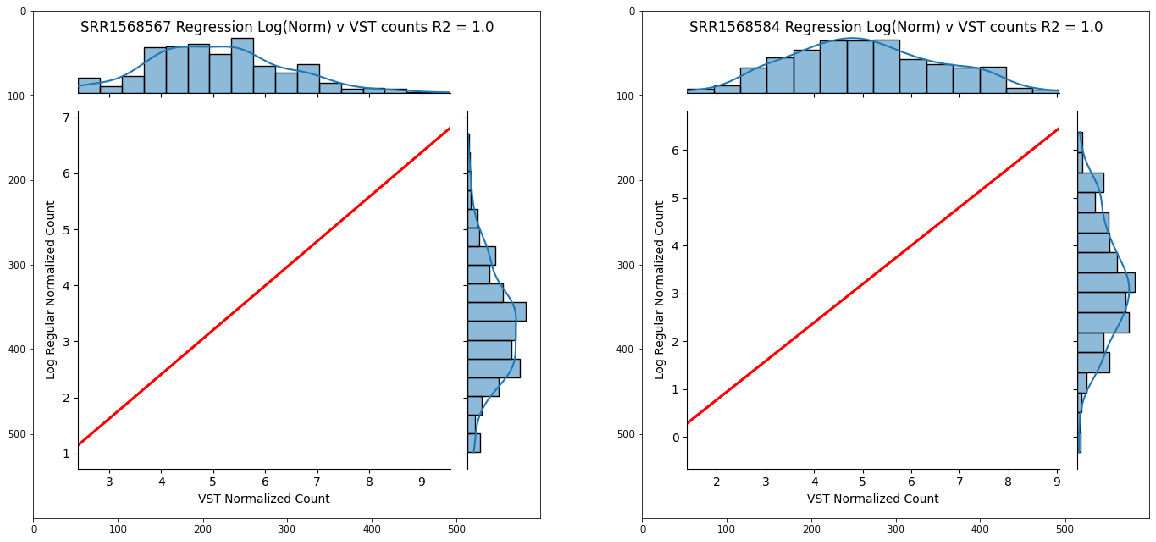

In [25]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/sra_1.png')
img_B = mpimg.imread('../data/out/sra_2.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);
plt.show()
display(HTML("<b>Figure "+str(figNum)+": Two SRA Run's regression of log norm vs VST counts. </b>"))
figNum += 1

### PCA

We performed Principle Component Analysis (PCA) on the VST gene matrix for two PCA Plots, one with the grouping set to disorder, and another plot with the grouping set to biofluid. 

PCA uses linear combinations to explain the variance-covariance structure of a set of variables. Data reduction and data interpretation are the main reasons for the use of PCA with the latter being the method we incorporated in the replication project[<sup>8</sup>](#fn8). For the purposes of this project, we did not remove any samples from our data thus negating the need to do any sort of dimensionality reduction of our data. In doing so, we did not experience any reduction in our data in terms of size and scope which would be commmon in other PCA implementations. We used PCA purely on an exploratory level where we could observe relationships within our data that may not have been as obvious to us. 
In Figure 14 below, there are visibly two groups formed in both the left and right charts. However, the spread of every disorder and biofluid, respectively, is relatively equal across the chart.


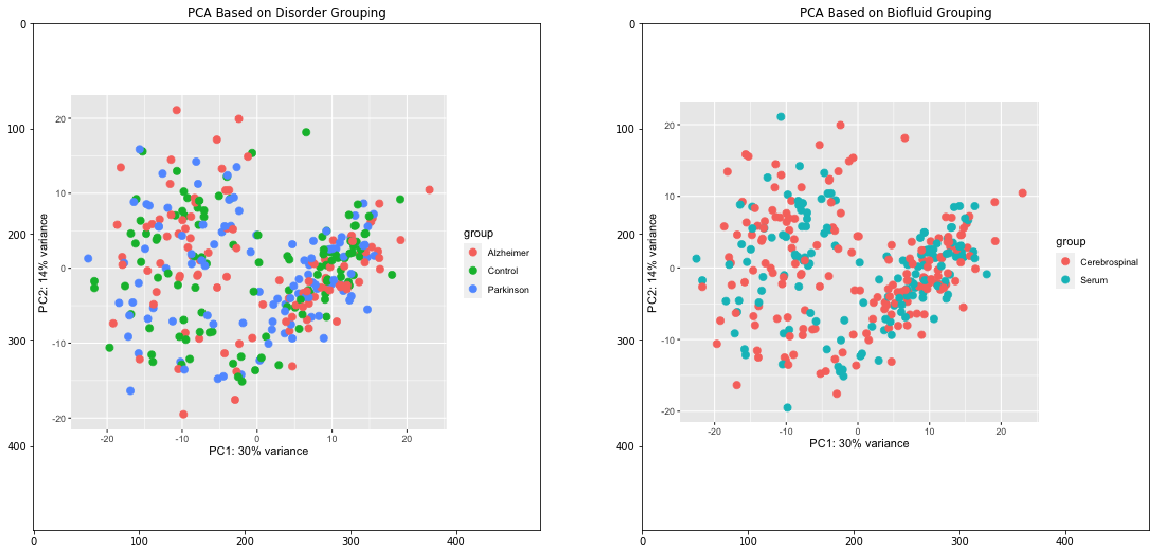

In [26]:
import matplotlib.image as mpimg

img_A = mpimg.imread('../data/out/PCAplot_Disorder.png')
img_B = mpimg.imread('../data/out/PCAplot_Biofluid.png')

# display images
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_A);
ax[1].imshow(img_B);

title = ax[0].set_title("PCA Based on Disorder Grouping")
title = ax[1].set_title("PCA Based on Biofluid Grouping")
plt.show()
display(HTML("<b>Figure "+str(figNum)+": (left) PCA based on grouping by disorder. (right) PCA based on grouping by biofluid. </b>"))
figNum += 1

### Missing Genes
The majority of the 180K genes are missing across all samples and are thus not relevant for analysis and comprimise quality and performance of the analysis. We can plot these genes to see the missingness percentage to see if there is a pattern related to the biofluid or gender. The plot below shows the missing genes do not have a pattern in any particular classification of patients. After removing the missing genes we end up with 132 genes that are in all the samples.

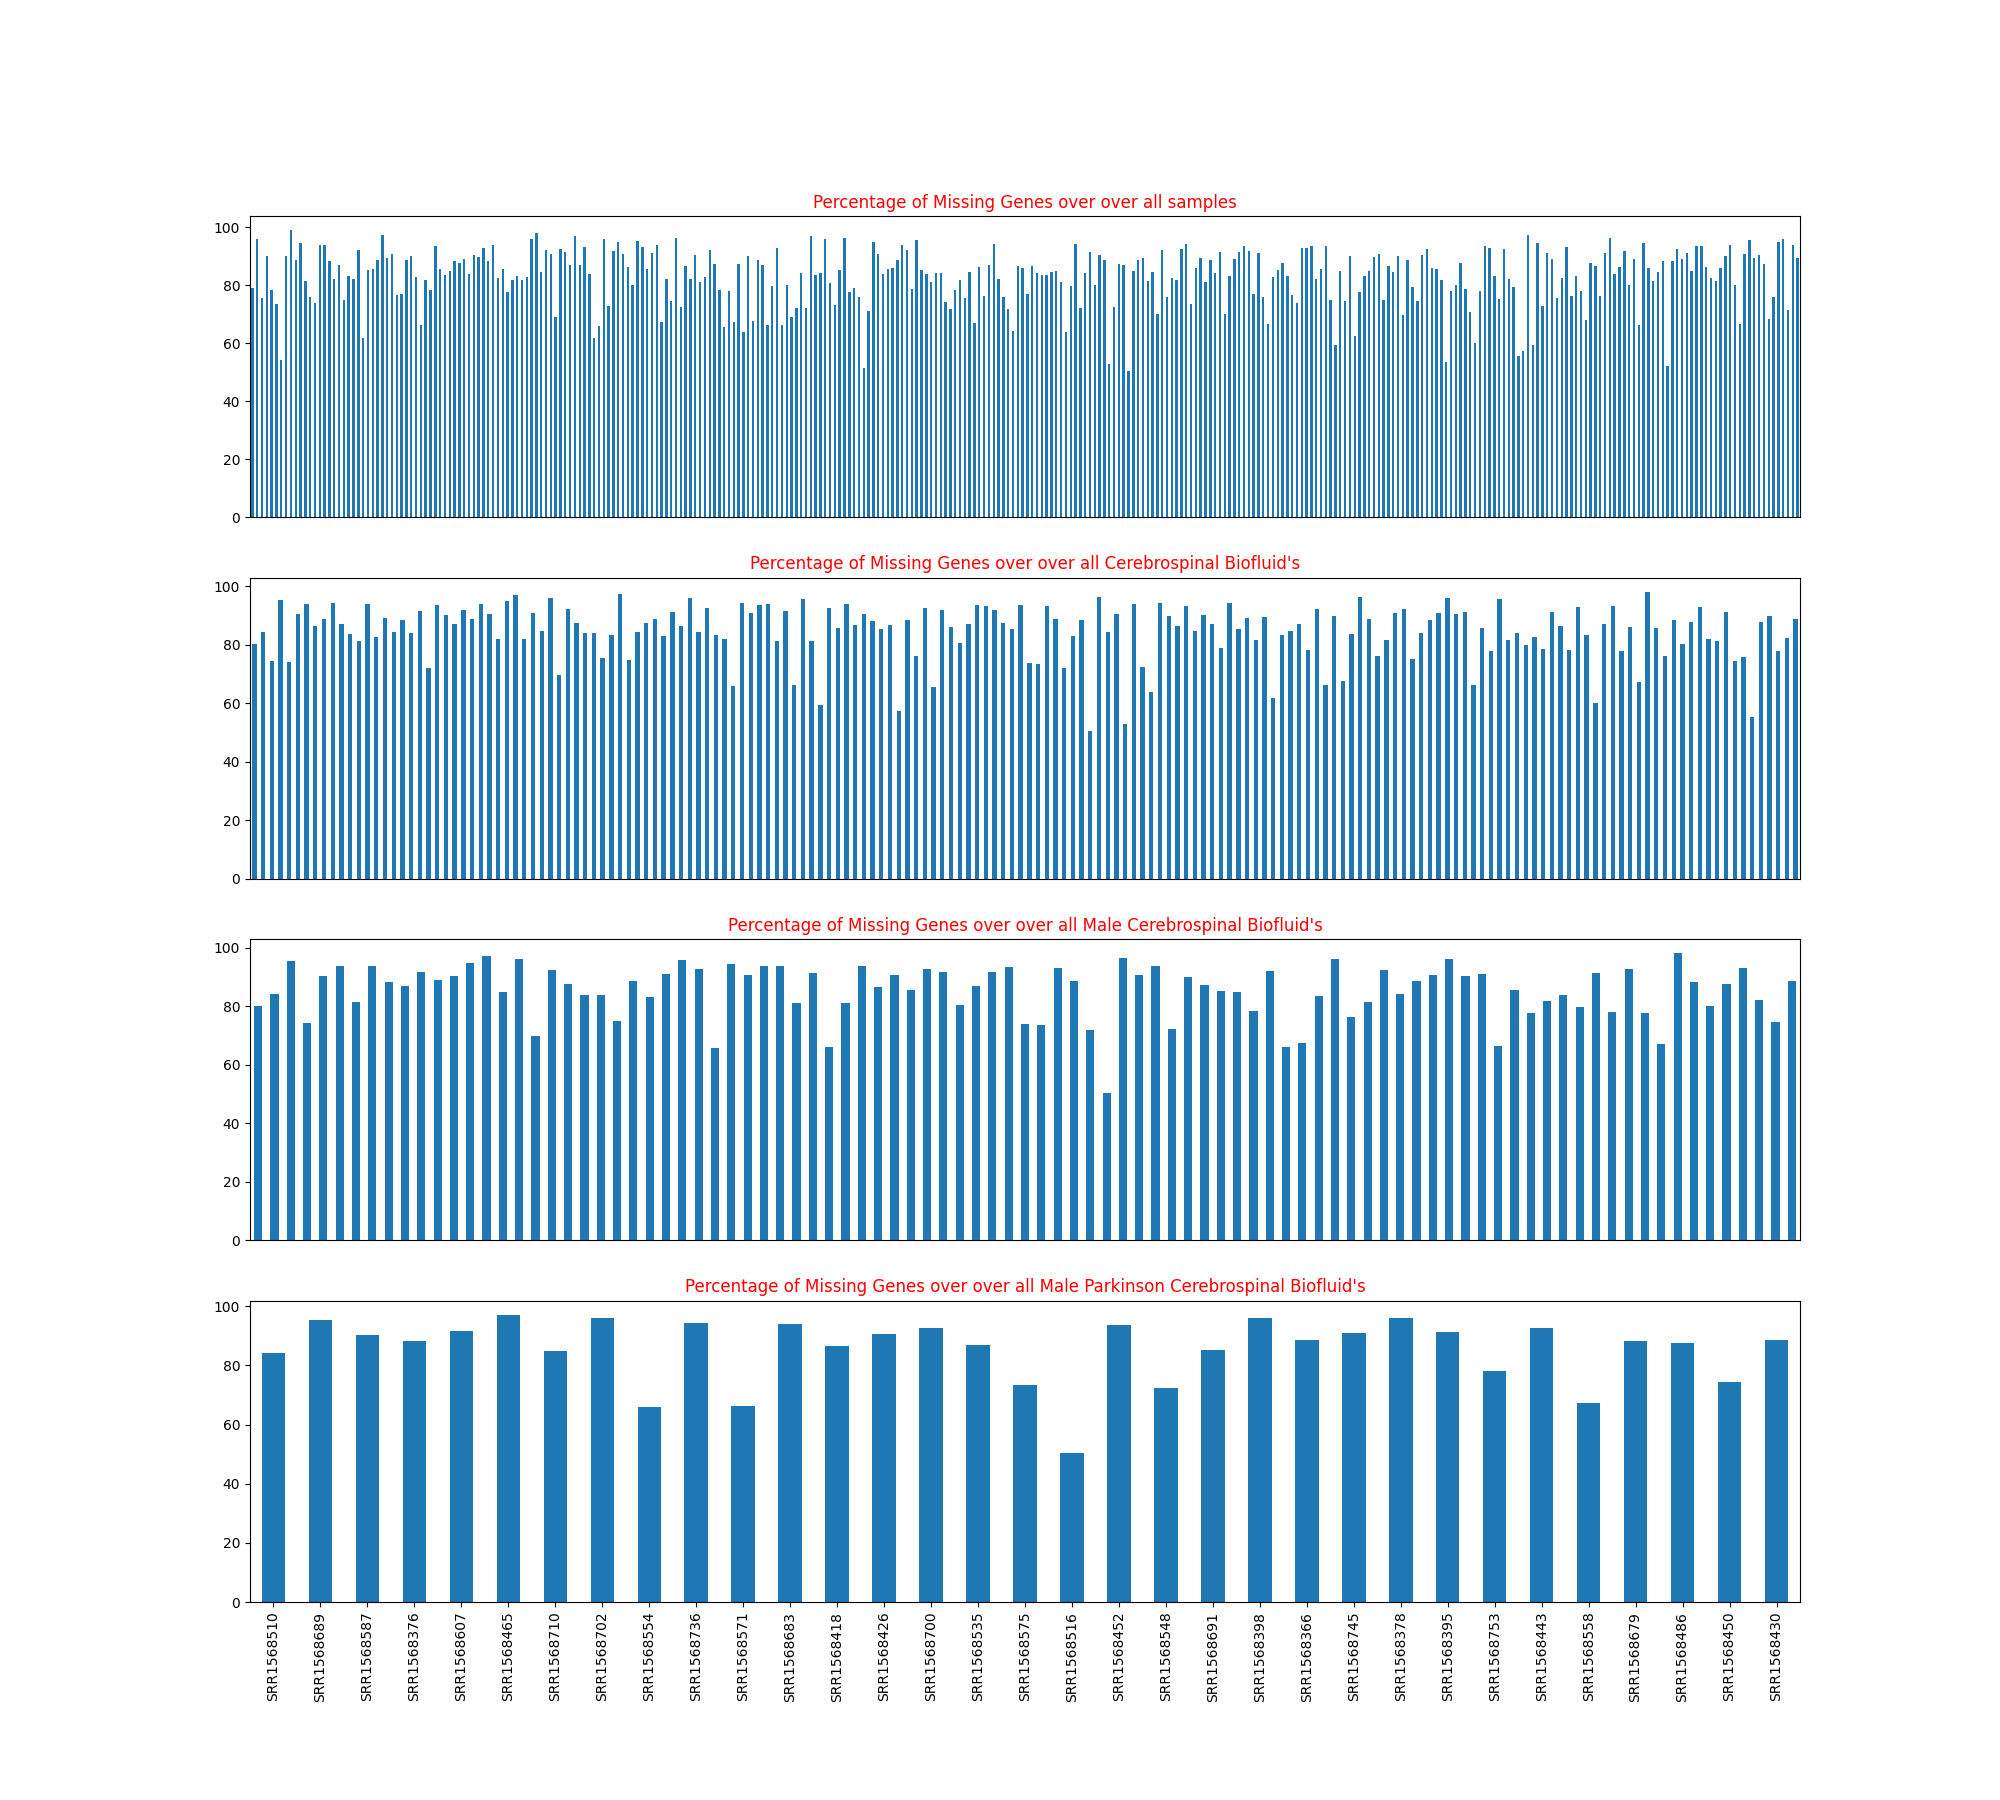

In [27]:
display(Image("../data/out/missing.png", width=800))
display(HTML("<b>Figure "+str(figNum)+": Missingness analysis of Genes. </b>"))
figNum += 1

Furthermore, we can identify the top and bottom genes based on a statistic for each gene across the samples that measures the spread against the mean normalized count. Genes which had little spread are likely candidates that might not be important as they do not significantly vary across the samples. The spread statistic we developed was the L1 distance against the mean. The table below shows the top 5 and bottom 5 genes and the spread values. The gene with highest count variance was NST00000538654.1:retained_intron:SNHG1-003 and the bottom ranked gene was ENST00000365436.1:misc_RNA:Y_RNA.387-201. <font color="red"> Finally, a gene that was mentioned in the paper, EGR1 (NM_001964), was ranked number 691. This ranking could indicate some potential data quality issues resulting from kallisto which was not used for gene counting in the original study. </font>

In [28]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))


df3 = pd.read_csv("../data/out/top_genes.tsv", sep='\t', index_col=0)
df3 = df3.rename({"gene": "Gene"}, axis=1)
display_side_by_side([df3.iloc[:5,:], df3.iloc[-5:,:]], ['Top Ranked Genes', 'Bottom Ranked Genes'])

display(HTML("<b>Table "+str(tableNum)+": (left) the top ranked genes and their spread. (right) the bottom ranked genes and their spread. </b>"))
tableNum += 1


,Gene,Spread
0,ENST00000271375.4:protein_coding:SFT2D2-001,859.272
1,ENST00000538183.2:protein_coding:SOD2-001,649.644
2,ENST00000315091.3:protein_coding:TARDBP-003,488.457
3,ENST00000240185.3:protein_coding:TARDBP-001,484.937
4,ENST00000245907.6:protein_coding:C3-001,420.103
,Gene,Spread
429,ENST00000395407.2:protein_coding:PAQR5-001,136.338
430,ENST00000284727.4:protein_coding:ATP5G3-001,134.769
431,ENST00000362487.1:misc_RNA:Y_RNA.24-201,132.802
432,ENST00000578231.1:misc_RNA:RN7SL3-201,123.799


## Data Analysis

The analysis of the data was performed using the same technique in the research paper, namely to consider each biofluid separately, and within inside each biofluid to consider each disorder (versus control) separately. This resulted in 4 combinations of analysis computations that were performed.  

With the top genes identified, each of the 2 biofluids ("Serum", "Cerebrospinal fluid") we filtered only the samples for that biofluid and then further break into 2 different tables where we would only include one of the 2 disorders ("Alzheimers", "Parkinsons") plus the control.

<span style="color:red"> The basis of the analysis was the Likelihood Ratio Test (LRT), which is a hypothesis test based on a full and reduced model using the DESeq2 package. The full model was Age+PMI+pH+Disorder, and the reduced model was Age+PMI+pH. The premise of the LRT is to compare models in terms of how they fit the available data by comparing the likelihood scores of the two models[<sup>9</sup>](#fn9). The model with the higher score is considered the model that best fits the data. In order to properly use the LRT, the models being compared must be nested models meaning one model must be a "simpler" version of the other[<sup>9</sup>](#fn9). In our case, the "simpler" model is our reduced model, while our full model represents out complex model. </span>

<span style="color:red">Our process for LRT in this replication project differs from the original paper in that the PRUA was not included, which as mentioned earlier was due to not having this statistic readily available due to our choice of using kallisto. The output from the analysis was a LRT table which included the baseMean, log2 Fold Change, stat, the pvalue, and adjusted pvalue. The descriptive summary of LRT in brain region AnCg for Major Depressive Disorder is shown in Table 13 below. </span>

In [29]:
df4 = pd.read_csv("../data/out/Cerebrospinal/Parkinson/lrt.tsv", sep='\t', index_col=0)
df4.describe().round(3)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
count,434.000,434.000,434.000,434.000,434.000,434.000
mean,57.628,-0.015,0.303,0.776,0.519,0.934
std,105.702,0.292,0.096,1.059,0.253,0.011
min,3.562,-1.054,0.189,0.000,0.008,0.932
25%,16.137,-0.193,0.233,0.110,0.302,0.932
50%,31.968,-0.002,0.278,0.387,0.534,0.932
75%,55.399,0.177,0.350,1.067,0.740,0.932
max,1269.717,1.083,1.307,7.080,0.997,0.997


Table 13: The LRT descriptive summary for biofluid Cerebrospinal fluid for Parkinsons.

## Visualization

### MA Plot

The LRT data for each of the 4 comparisons was used to generate a 2x2 MA Plot shown in Figure 16 below. This is a scatter plot of the mean of the normalized counts against the log fold change. 
<span style="color:red"> The striking pattern we can see is that the brain region AnCg and the disorder for Schizophrenia shows many outliers. Our findings for the MA Plot results between schizophrenia and the anterior cingulate cortex are inline with the behavior observed by data of the schizophrenic samples within the specific brain region. Specifically, the original replication report notes that schizophrenic samples in the AnCg showed the most significant disease-related differences compared to those of the control groups[<sup>1</sup>](#fn1). </span>


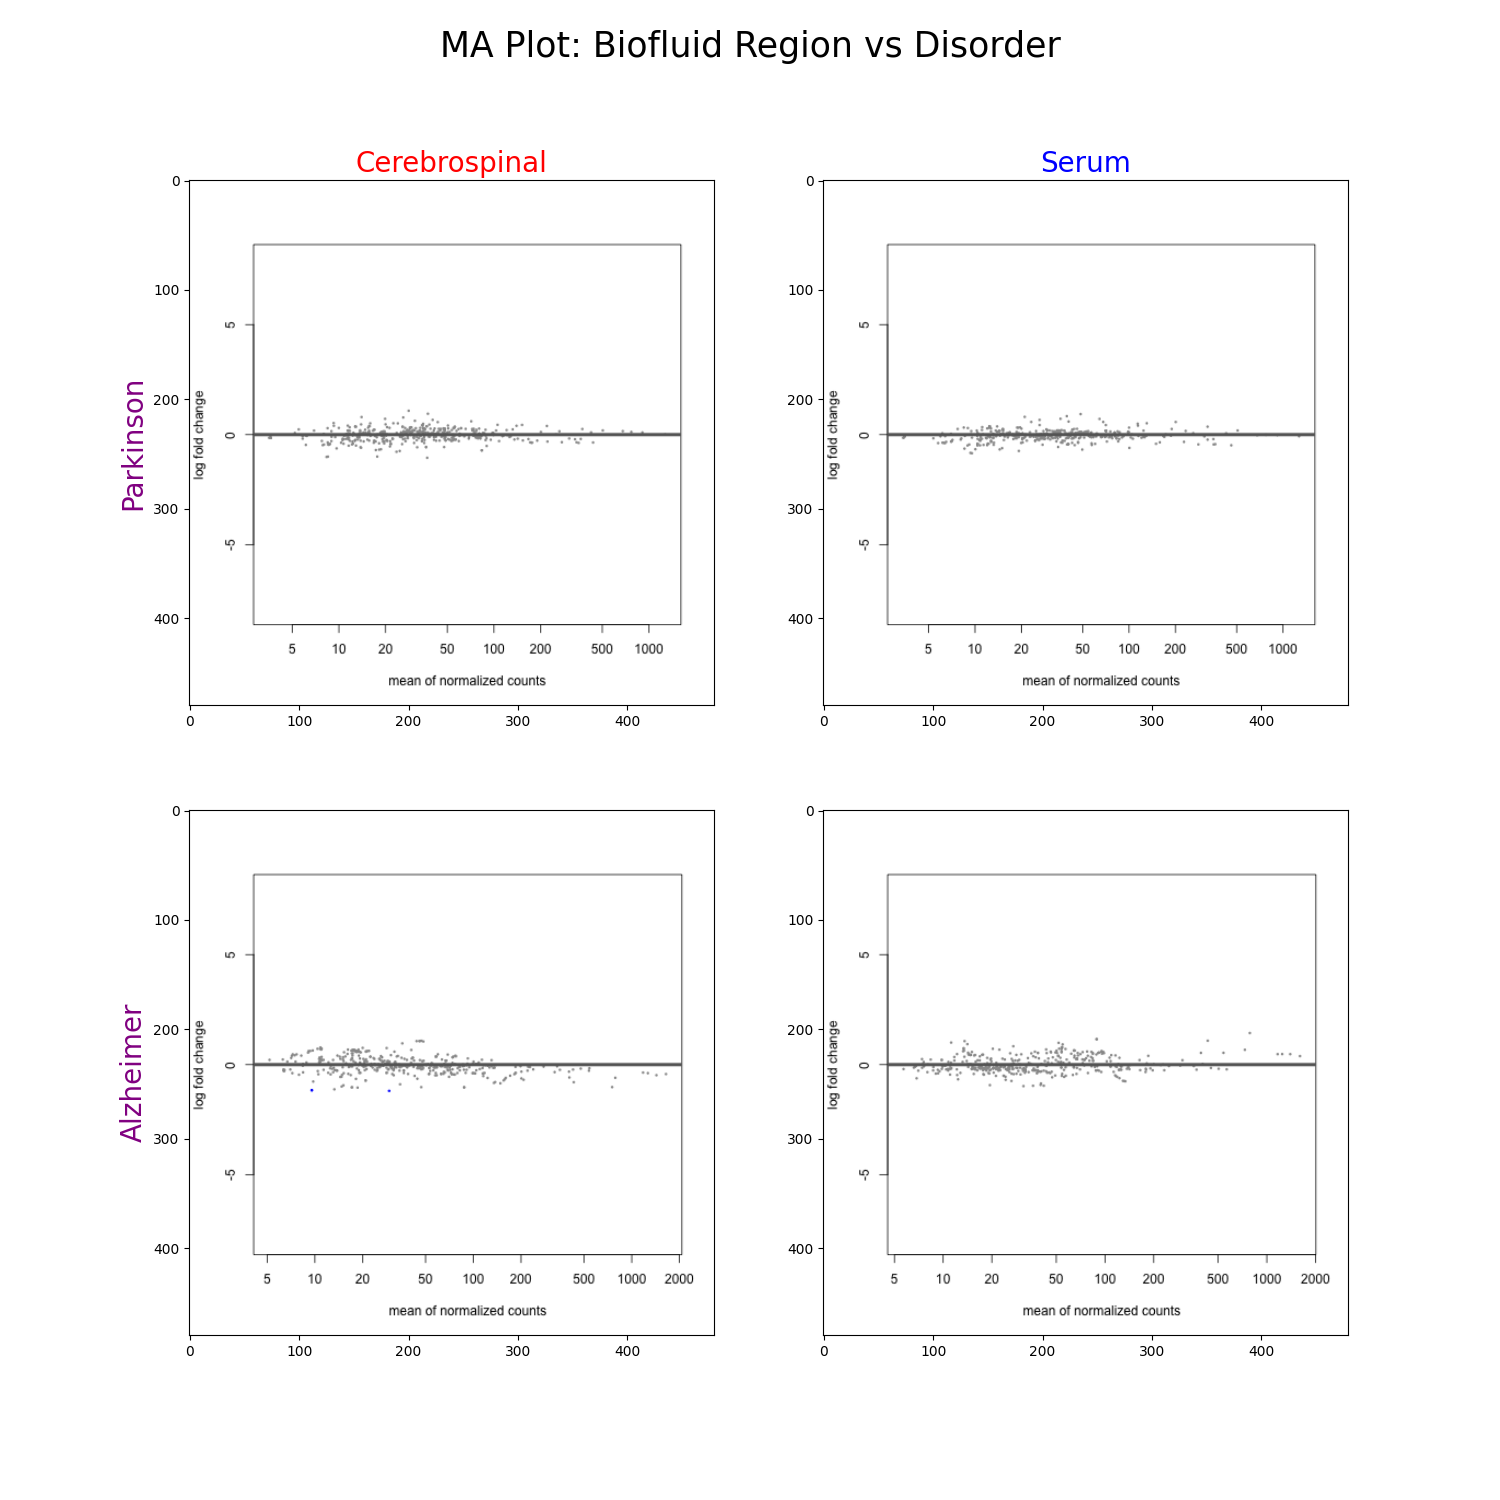

In [30]:
display(Image("../data/out/ma_plot.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": MA Plot for each biofluid versus each disorder. </b>"))
figNum += 1

### Heat Maps

The LRT data for each of the 4 analysis regions was used to generate a 2x2 heatmaps of the top 100 genes is shown in Figure 17 below. Heatmaps allow us to observe specific values of interest across two axis variables in the form of a grid with colored cells[<sup>10</sup>](#fn10). The variables we have used for our axes are the patients and the genes identified across our patient samples, with the main value of interest being the expression of genes between patients and specific genes, which was a similar approach seen in the original replication paper. By observing our value of interest, gene expression, we can then be able to determine if any patterns or associations exist within our 9 analysis regions. Figure 17 shows clustering analysis which is particulalry suited to the VST data. <span style="color:red"> Although it is difficult to interpret the minute details in each chart, we can see that two areas are more different than others: Major Depressive in both the brain regions of DLPFC and nAcc show striking differences to the rest of the heatmaps. </span>

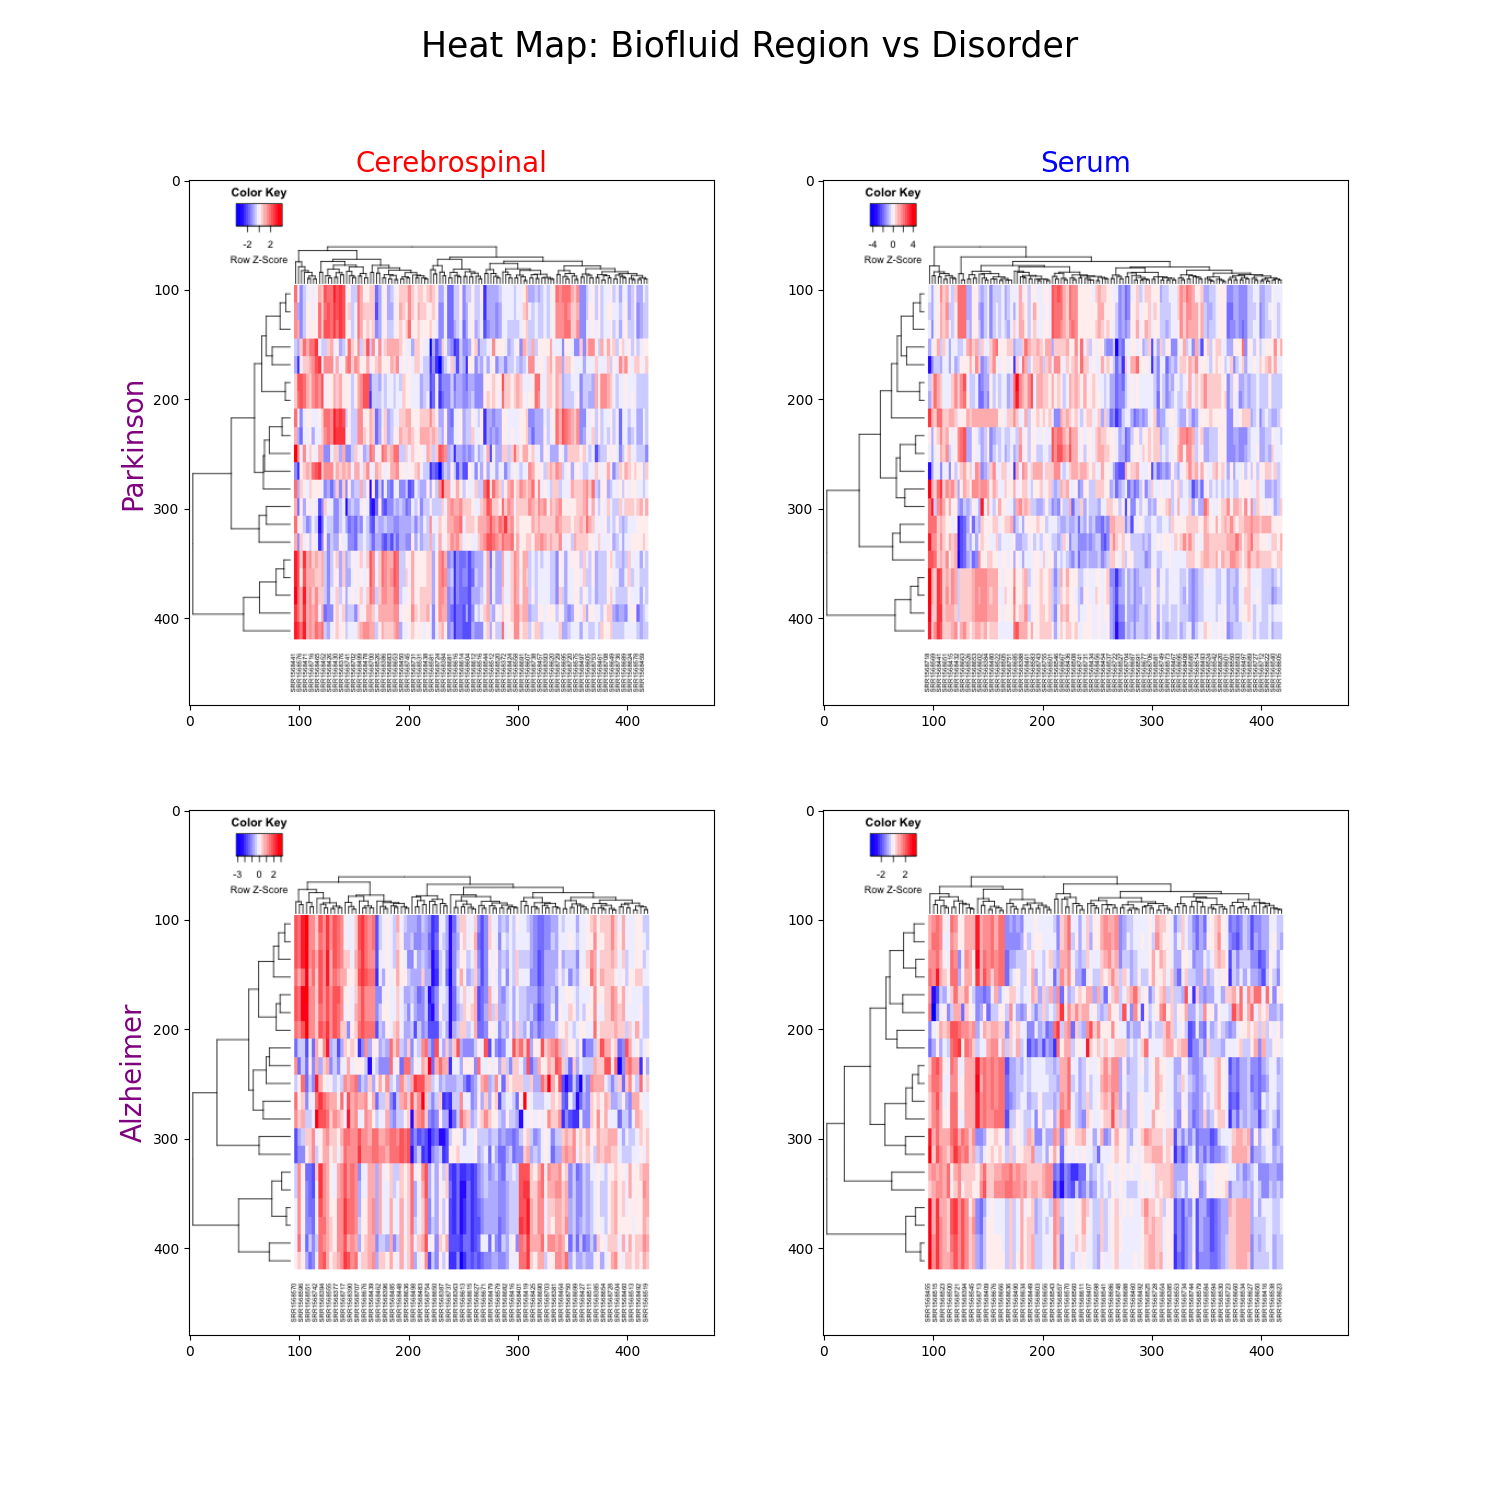

In [31]:
display(Image("../data/out/heat_map.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Top 100 Expressed Gene Heatmap for each biofluid versus each disorder. </b>"))
figNum += 1

### Histograms of case versus control differential expression

We repeat the same visualization in the paper for the distribution of the pvalues for each of the 4 regions shown in Figure 18 below. <span style="color:red">We see a similar profile for the Schizophrenia histograms - AnCg has a distribution which has a right skewed with a high number of samples with high statistical significance. Similarly, Schizophrenia histograms for DLPFC and nAcc show a flattish distribution. The Bipolar Disorder for AnCg also shows a similar right skewed distribution with a lower peak than Schizophrenia in this same brain region. The distributions for the other regions is not exactly the same as in the paper. However, given the large number of differences in the processing pipeline, in particular the use of kallisto, there is still a reasonable degree of correlation in these results. </span>

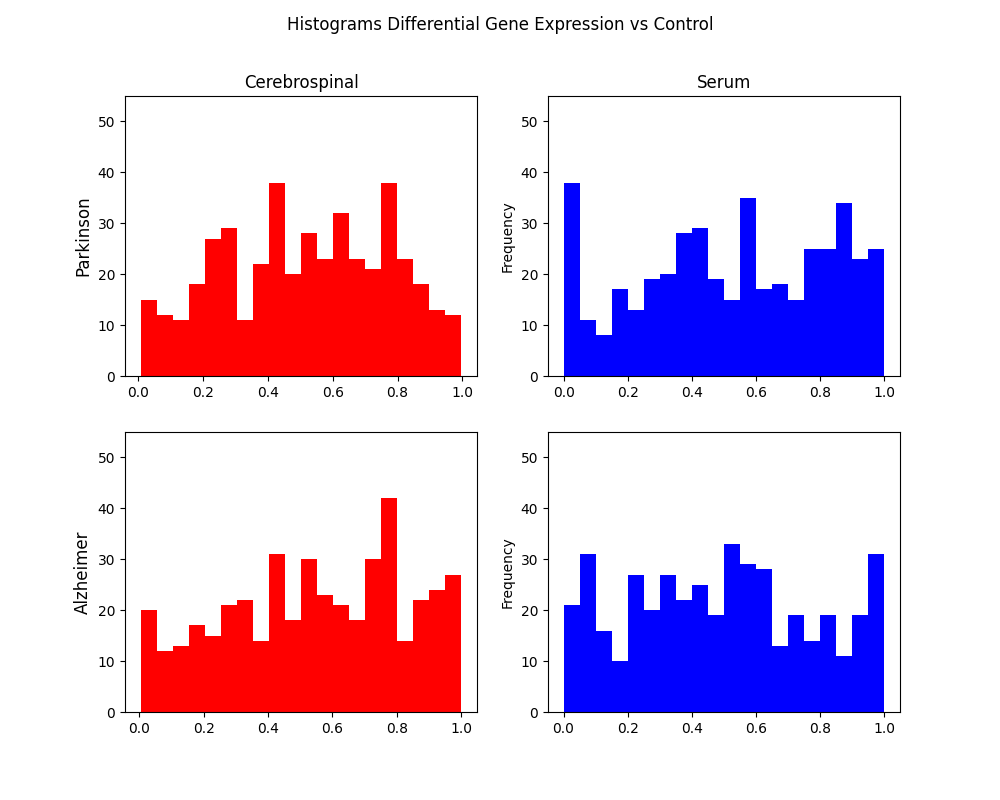

In [32]:
display(Image("../data/out/histogram.png", width=800))
display(HTML("<b>Figure "+str(figNum)+": Histogram for each biofluid versus each disorder. </b>"))
figNum += 1

### Venn Diagram of Disorders 

Another visualization in the original paper is a venn diagram that shows overlap of genes differentially expressed between Parkinson (red) and Alzheimer (green) <span style="color:red"> versus CTL at p value <0.05 in the AnCg, our venn diagram is shown below in Figure 19. The actual numbers are different and is to be expected as we do not know the exact number of genes that were dropped as part of PCA in the research paper. However, there is a significant divergence in the Major Depressive Disorder with only 312 counts measured which indicates that our analysis is not replicating the same results in this disorder - this was also seen in the histogram analysis mentioned above too. This is a potential area to investigate and debug to find the cause of this divergence.</span>

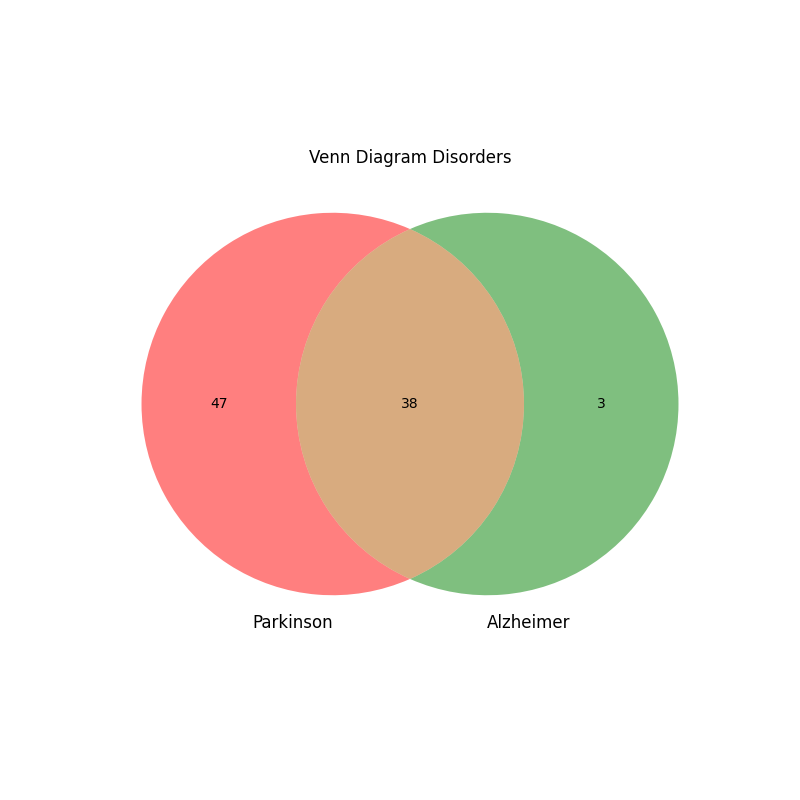

In [33]:
display(Image("../data/out/venn.png", width=600))
display(HTML("<b>Figure "+str(figNum)+": Venn Diagram showing genetic overlap between Parkinson and Alzheimer. </b>"))
figNum += 1

### Spearman correlations of log2 fold gene expression 

We finally recreate the spearman correlation matrix that is pairwise Spearman correlations of log2 fold gene expression changes between each disorder and CTL in each biofluid. The circle sizes are scaled to reflect absolute Spearman correlations. To produce this plot we took the log2 fold gene expressions column from each of the 4 LRT analyses we performed and then use Panda's correlation function to generate a R2 pearson correlation number.

The results are shown below in Figure 20. <span style="color:red"> One particularly interesting point is that we see a high degree of correlation between Schizophrenia and Bipolar disorders in the AnCg brain region, this was also noted in the research paper and is a likely confirmation that our results have some level of validity. </span>


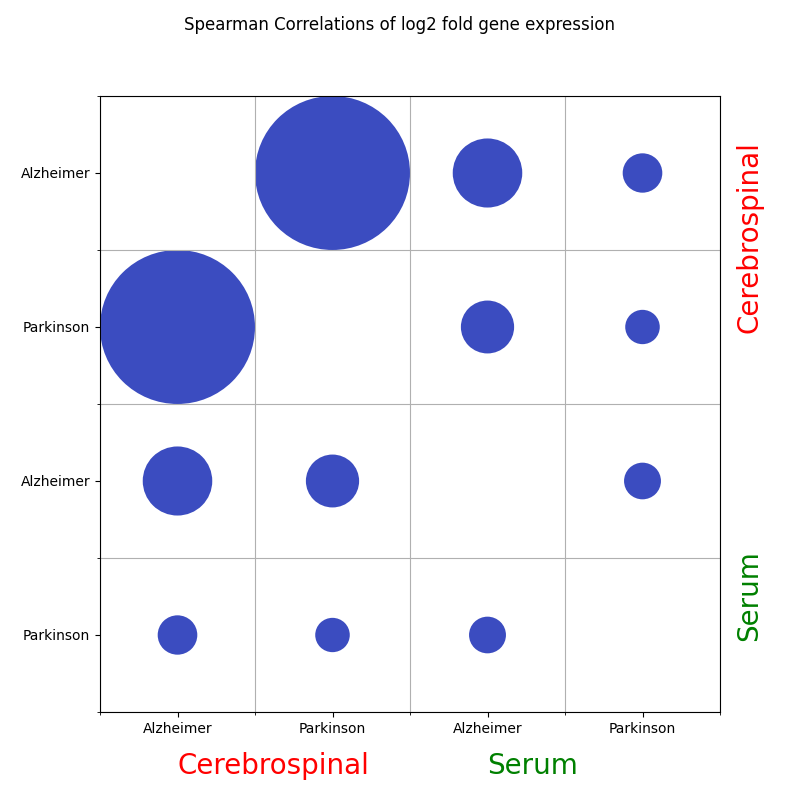

In [34]:
display(Image("../data/out/corrmatrix.png", width=500))
display(HTML("<b>Figure "+str(figNum)+": Spearman correlation of log2 fold gene expression for each biofluid against each disorder. </b>"))
figNum += 1

## Conclusion TODO

<span style="color:red"> #TODO </span>
We have shown a reproduction of the brain and disorder analysis using gene expressions. To accomplish this we have developed a robust pipeline which takes SRA fastq files and outputs visualizations that are in the original paper. Although we do not match the exact results, we have shown that we do find that there is a high degree of correlation in the AnCg brain region between Schizophrenia and Bipolar disorders. However, we have found our results diverge in the Major Depressive disorder. This discrepency could have occurred because of several decisions we made different from the original paper:

- We decided to develop a custom pipeline instead of using the aRNAPipe. aRNAPipe is used in the paper and is very powerful but we decided we wanted to call the tools (cutadapt, kallisto, etc) directly in our own pipeline as it gives us more ability to understand what is going on, more flexibility, and we think it will be easier to debug in the future.

Overall, this was a great learning experiance for both of the team members. Not only was it a technically challenging project from learning new tools and developing a sophisticated pipeline, but we also learned about the biology of genes and approaches of using gene expression to analyse massive real-world datasets. This project also allowed us to appreciate the data challenges that data scientists in the genetics field face, from incomplete data to massive computation challenges to clean and process the biological sample datasets. 


# Appendix

## Project Targets

### Running the project

•	To install the dependencies, run the following command from the root directory of the project: 

    pip install -r requirements.txt


### target: data
•	To process the data, from the root project directory run the command:

    python3 run.py data

•   The data pipeline step takes the .fastq compressed files as input and then applies two transformations: process and align

•	This pipeline step also uses an additional CSV file that is the SRA run database, a sample looks like as follows:

    Run expired_age    CONDITION    BIOFLUID     
    SRR1568567  40  Parkinson's Disease Cerebrospinal 



•   The configuration files for the data step are stored in config/data-params.json. These include the parameters for the tools as well as the directories used for storing the raw, temporary and output files.

    "raw_data_directory": "./data/raw",
    "tmp_data_directory": "./data/tmp",
    "out_data_directory": "./data/out",

•   The configuration also includes an attribute to the SRA run input database (described above), and an attribute of where to store that in the data folder. Additional filter attributes are included for ease of use to avoid processing all patients, if this filter_enable is set it will only process a subset of SRA rows (filter_start_row to filter_start_row + filter_num_rows).

    "sra_runs" : {
        "input_database" : "/datasets/SRP046292/exRNA_Atlas_CORE_Results.csv",
        "input_database2" : "/datasets/SRP046292/SraRunTable.csv",
        "input_database3" : "/datasets/SRP046292/Table_S1.csv",
        "output_database" : "data/raw/exRNA_Atlas_CORE_Results.csv",
        "filter_enable" : 0,
        "filter_start_row" : 120,
        "filter_num_rows" : 10   
    },
    

•	An optional transformation of the data is "process" that uses the following data configuration below that will invoke cutadapt which finds and removes adapter sequences. The attributes include the adapters (r1 and r2) to identify the start and end of pairs are a JSON array. The attribute enable allows to disable this cleaning step, instead it will simply copy the paired files from the source dataset. The arguments attribute allows flexible setting of any additional attribute to the cutadapt process. Finally, we have two wildcard paths that indicate the location of the SRA fastq pair files (fastq1 and fastq2).

    "process" : {
        "enable" : 1,
        "tool" : "/opt/conda/bin/cutadapt",
        "r1_adapters" : ["AAAAA", "GGGG"],
        "r2_adapters" : ["CCCCC", "TTTT"],
        "arguments" : "--pair-adapters --cores=4",
        "fastq1_path" : "/datasets/srp073813/%run_1.fastq.gz", 
        "fastq2_path" : "/datasets/srp073813/%run_2.fastq.gz"
    },
    
•   The second transformation of the data is "aligncount" that can be set to either use download, STAR or Kallisto. The choice is controlled by the aligncount attribute:

    "aligncount" : "download",

•   download step will use the ftp location of the gzip file in the Sra table and download using the curl command and unzips and the extracts the readCounts_gencode_sense.txt which represents thae gene counts for the sample. 

    "download" : {
        "enable" : 1,
        "tool" : "curl",
        "arguments" : "-L -R",
        "read_counts_file" : "readCounts_gencode_sense.txt"
    },

•   kallisto uses the index_file attribute is the location of the directory of the reference genome, which for this replication project was GRCh37_E75. The arguments attribute allows flexible setting of any additional attribute to the kallisto process. Including the bootstaro samples.The attribute enable allows to disable this alignment step, this is useful for debugging the process prior step, for example, you can run quality checks on the processed fastq files before proceeding to alignment. 

    "kallisto" : {
        "enable" : 1,
        "tool" : "/opt/kallisto_linux-v0.42.4/kallisto",
        "index_file" : "/datasets/srp073813/reference/kallisto_transcripts.idx",
        "arguments" : "quant -b 8 -t 8"
    },

•   STAR uses the gene_path attribute is the location of the directory of the reference genome, which for this replication project was GRCh37_E75 as described in the reference_gene attribute. The arguments attribute allows flexible setting of any additional attribute to the STAR process. Including TranscriptomeSAM in the quantMode arguments will also output bam files. Additionally, the log file gets outputted which has PRUA (percentage of reads uniquely aligned). The attribute enable allows to disable this alignment step, this is useful for debugging the process prior step, for example, you can run quality checks on the processed fastq files before proceeding to alignment. 

    "STAR" : {
        "enable" : 1,
        "tool" : "/opt/STAR-2.5.2b/bin/Linux_x86_64_static/STAR",
        "reference_gene" : "GRCh37_E75",
        "gene_path" : "/path/to/genomeDir",
        "arguments" : "--runMode alignReads --quantMode GeneCounts --genomeLoad LoadAndKeep --readFilesCommand zcat --runThreadN 8"
    },




•   The process and align transformation work on each of the samples. After each sample iteration, the temporary fastq files will be deleted to reduce storage requirements.


•   Example processing:

    python3 run.py data

    # ---------------------------------------------------
    # Process
    # ---------------------------------------------------
    # ---------------------------------------------------
    # Starting sample # 1 out of 1
    # ---------------------------------------------------
    # Starting sample # 1 out of 343
    curl-proxy -L -R -o ./data/tmp/SRR1568613.tgz ftp://ftp.genboree.org/exRNA-atlas/grp/Extracellular%20RNA%20Atlas/db/exRNA%20Repository%20-%20hg19/file/exRNA-atlas/exceRptPipeline_v4.6.2/KJENS1-Alzheimers_Parkinsons-2016-10-17/sample_SAMPLE_1022_CONTROL_SER_fastq/CORE_RESULTS/sample_SAMPLE_1022_CONTROL_SER_fastq_KJENS1-Alzheimers_Parkinsons-2016-10-17_CORE_RESULTS_v4.6.2.tgz
    sh: curl-proxy: command not found
    mkdir ./data/tmp/SRR1568613
    tar -C ./data/tmp/SRR1568613 -xzf ./data/tmp/SRR1568613.tgz
    cp ./data/tmp/SRR1568613/data/readCounts_gencode_sense.txt ./data/tmp/SRR1568613_ReadsPerGene.out.tab
    # ---------------------------------------------------
    # Starting sample # 2 out of 343
    curl-proxy -L -R -o ./data/tmp/SRR1568457.tgz ftp://ftp.genboree.org/exRNA-atlas/grp/Extracellular%20RNA%20Atlas/db/exRNA%20Repository%20-%20hg19/file/exRNA-atlas/exceRptPipeline_v4.6.2/KJENS1-Alzheimers_Parkinsons-2016-10-17/sample_SAMPLE_0427_PD_CSF_fastq/CORE_RESULTS/sample_SAMPLE_0427_PD_CSF_fastq_KJENS1-Alzheimers_Parkinsons-2016-10-17_CORE_RESULTS_v4.6.2.tgz
    sh: curl-proxy: command not found
    mkdir ./data/tmp/SRR1568457
    tar -C ./data/tmp/SRR1568457 -xzf ./data/tmp/SRR1568457.tgz
    cp ./data/tmp/SRR1568457/data/readCounts_gencode_sense.txt ./data/tmp/SRR1568457_ReadsPerGene.out.tab
    # ---------------------------------------------------


### target: merge
•   To merge gene count and/or BAM files generated from the data target, from the root project directory run the command:

    python3 run.py merge

•   The configuration files for the data step are stored in config/count-params.json. These include the parameters for the count merge and bam merge and it's associated arguments.

•   The format attrbute informs if to process downlload, kallisto (or STAR) files. The gene counts are merged into a TSV file and as well as a feature table based on the SRA run table. Additional STAR attributes in the JSON allow you to specify skiprows used when processing the  gene count files as well as identifying the column from the  gene matrix file to use as the column used to. There is an additional imputes attribute that allows you to impute any column with missing data. The attributes also include an optional "filter_names" gene table used to remove genes as well as removing false-positive genes. Finally, we can rename the feature columns before we save out the feature table.

    "count" : {
        "enable" : 1,
        "format" : "download",
        "skiprows" : 4,
        "column_count" : 1,
        "skip_samples" : ["SRR1568391"],
        "enable_filter" : 0,
        "filter_keep_genes" : "NM_",
        "filter_remove_genes" : ["chrX", "chrY"],
        "filter_names" : "/datasets/srp073813/reference/Gene_Naming.csv",
        "run_database" : "data/raw/exRNA_Atlas_CORE_Results.csv",
        "imputes" : ["TangleTotal"],
        "features" : ["Run", "CONDITION", "expired_age", "BIOFLUID", "sex", "PMI", "sn_depigmentation", "Braak score", "TangleTotal", "Plaque density", "PlaqueTotal"],
        "rename" : {"CONDITION" : "Disorder", "BIOFLUID" : "Biofluid", "Braak score" : "Braak_Score", "Plaque density" : "Plaque_density"},
        "replace" : {"from":["Parkinson's Disease", "Alzheimer's Disease", "Cerebrospinal fluid", "Healthy Control"], "to":["Parkinson", "Alzheimer", "Cerebrospinal", "Control"]},
        "output_matrix" : "data/out/gene_matrix.tsv",
        "output_features" : "data/out/features.tsv"
    },

•   For bam merging, which should not be enabled by default, we use the "samtools" merge feature that takes all the BAM files and combine them into one merged BAM file. 


    "bam" : {
        "enable" : 0,
        "output" : "data/tmp/merged.bam",
        "tool" : "/usr/local/bin/samtools",
        "arguments" : "merge --threads 8"
    },


•   Example processing:

    python3 run.py merge

    # ---------------------------------------------------
    # Merge
    Input: SRR3438605_ReadsPerGene.out.tab
    Input: SRR3438604_ReadsPerGene.out.tab
    Output: data/out/gene_matrix.tsv data/out/features.tsv
    # Finished
    # ---------------------------------------------------



### target: normalize
•   To normalize the aligned merge counts, from the root project directory run the command:

    python3 run.py normalize

•   The configuration files for the data step are stored in config/normalize-params.json. 

•   We use a custom R script which uses the DESeq2 module to take the input merged gene counts and the experiment features and outputs two normalized counts files. The analysis is done for all samples in the SRA run table. The output_dir sets the output location for the normalized count matrix files. One file is the standard normalized counts using the DESeq2 module, and the second normalized count file is after a Variable Stablization Transform (LRT). We also have a "max_genes" attribute that will filter the genes and removes ones that have little to no variance across disorder vesus control.

•   The data JSON configuration file also holds an array of samples, a sample looks like as follows:
    
    {
        "output_dir" : "data/out",
        "DESeq2" : {
            "Rscript" : "/opt/conda/envs/r-bio/bin/Rscript",
            "source" : "src/data/normalize.r",
            "input_counts" : "data/out/gene_matrix.tsv",
            "input_features" : "data/out/features.tsv",
            "max_genes" : 8000
        },
        "cleanup" : 0,
        "verbose": 1
    }


•   Example processing:

    python3 run.py normalize

    # ---------------------------------------------------
    # Normalize
    Rscript  src/data/normalize.r data/out/gene_matrix.tsv data/out/features.tsv data/out/
    [1] "Output data/out/normalized_counts.tsv data/out/vst_transformed_counts.tsv"
    # Finished
    # ---------------------------------------------------


### target: analysis
•   To perform the analysis for the gene counts, from the root project directory run the command:

    python3 run.py analysis

•   The configuration files for the data step are stored in config/analysis-params.json. 

•   We use a custom R script which uses the DESeq2 module to take the input merged gene counts and the experiment features and outputs 2 sets of files for each biofluid region. Each biofluid region will compare a disorder versus Control. This will result in a total of 4 sets of files (2 biofluid regions x 2 disorder pair comparisons). Each output set includes a Likelihood Ratio Test (LRT) using the full and reduced model as specified in the attributes below as well as a MA-Plot and Heatmap. The additional attributes include the property of doing parallel processing for DESeq2.
    
    {
        "output_prefix" : "data/out/%biofluid_region%",
        "DESeq2" : {
            "Rscript" : "/opt/conda/envs/r-bio/bin/Rscript",
            "biofluid_regions" : ["Cerebrospinal", "Serum"],
            "disorders" : ["Parkinson", "Alzheimer"],
            "control" : "Control",
            "input_counts" : "data/out/pca_normalized_counts.tsv",
            "input_features" : "data/out/features.tsv",
            "source" : "src/analysis/analysis.r",
            "full" : "expired_age+sex+PMI+sn_depigmentation+Braak_Score+TangleTotal+Plaque_density+PlaqueTotal+Disorder",
            "reduced" : "expired_age+sex+PMI+sn_depigmentation+Braak_Score+TangleTotal+Plaque_density+PlaqueTotal",
            "parallel" : 0
        },
        "cleanup" : 0,
        "verbose": 1
    }


•   Example processing:

    python3 run.py analysis

    # ---------------------------------------------------
    # Analysis
    Cerebrospinal x Parkinson vs Control
    Rscript src/analysis/analysis.r data/out/Cerebrospinal/Parkinson/gene_matrix.tsv data/out/Cerebrospinal/Parkinson/features.tsv data/out/Cerebrospinal/Parkinson/ full=expired_age+sex+PMI+sn_depigmentation+Braak_Score+TangleTotal+Plaque_density+PlaqueTotal+Disorder reduced=expired_age+sex+PMI+sn_depigmentation+Braak_Score+TangleTotal+Plaque_density+PlaqueTotal charts=1 parallel=0


### target: visualize

•   The visualize pipeline step can be invoked as follows:

    python3 run.py visualize

•   The configuration files for the data step are stored in config/visualize-params.json. The output will include multiple sets of charts: Gene Spread Variance Histogram, SRA Linear Correlation between SRA chart, MA-Plot 2x2 chart, Heat Map 2x2 chart, 2x2 Histogram, 4x4 Correlation Matrix and a Disorder Venn Diagram. Each chart type has flexible settings to control the input and layout for the charts as shown below:

    "gene_hist" : {
        "enable" : 1,
        "max_genes" : 8000,
        "nbins" : 100,
        "title" : "Distribution of Genes Based on Spread Metric: All vs Top Genes"
    },
    "missing_plot" : {
        "enable" : 1,
        "title" : "Percentage of Missing Genes over"
    },
    "sra_lm" : {
        "enable" : 1,
        "sra" : ["SRR1568567", "SRR1568584"],
        "normalized_counts" : "data/out/normalized_counts.tsv",
        "vst_counts" : "data/out/vst_transformed_counts.tsv",
        "title" : "%sra% Regression Log(Norm) v VST counts"
    },
    "ma_plot" : {
        "enable" : 1,
        "biofluid_regions" : ["Cerebrospinal", "Serum"],
        "disorders" : ["Parkinson", "Alzheimer"],
        "src_image" : "MAplot.png",
        "title" : "MA Plot: Biofluid Region vs Disorder"
    },
    "heat_map" : {
        "enable" : 1,
        "biofluid_regions" : ["Cerebrospinal", "Serum"],
        "disorders" : ["Parkinson", "Alzheimer"],
        "src_image" : "heatmap.png",
        "title" : "Heat Map: Biofluid Region vs Disorder"
    },
    "histogram" : {
        "enable" : 1,
        "biofluid_regions" : ["Cerebrospinal", "Serum"],
        "disorders" : ["Parkinson", "Alzheimer"],
        "title" : "Histograms Differential Gene Expression vs Control",
        "ylim" : 55
    },
    "corrmatrix" : {
        "enable" : 1,
        "title" : "Spearman Correlations of log2 fold gene expression"
    },
    "venn" : {
        "enable" : 1,
        "biofluid_regions" : ["Cerebrospinal", "Serum"],
        "disorders" : ["Parkinson", "Alzheimer"],
        "pvalue_cutoff" : 0.05,
        "title" : "Venn Diagram Disorders"
    },


•   Example processing:

    python3 run.py visualize

    # ---------------------------------------------------
    # Visualize
    # Finished
    # ---------------------------------------------------


### target: qc

•   The quality pipeline step can be invoked as follows:

    python3 run.py qc

•   The configuration files for the data step are stored in config/qc-params.json. These include the parameters for the output directory where the quality HTML reports will be outputted. 

    "outdir" : "data/out",
    "inputs" : "data/tmp",

•   For fastq files, the quality tool attribute is set to fastqc and that includes attributes to extract reports or keep them in a zip file. To enable this quality check make sure you set the cleanup to 0 in the data configuration pipeline as well as to disable the STAR processing, this will retain the fastq.qz files after the data pipeline step is executed.

    "fastq" : {
        "enable" : 1,
        "tool" : "/opt/FastQC/fastqc",
        "extract" : 1   
    },

•   For bam files, the quality tool attribute is set to picard and that includes attributes such as collecting alignment summary metrics. To enable this quality check make sure you set the cleanup to 0 in the data configuration pipeline and add 'TranscriptomeSAM' to the arguments for STAR which will then output BAM files that will be retained after the data pipeline step is executed.

    "bam" : {
        "enable" : 1,
        "tool" : "java",
        "jar" : "/opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar"
    },
    

•   Example processing:

    python3 run.py qc

    # ---------------------------------------------------
    # Quality Check
    fastqc data/tmp/out.1.fastq.gz --outdir=data/out --extract
    fastqc data/tmp/out.2.fastq.gz --outdir=data/out --extract
    java -jar /opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar INPUT=data/tmp/SRR3438604_Aligned.bam OUTPUT=data/out/SRR3438604_Aligned.bam.txt
    java -jar /opt/picard-tools-1.88/CollectAlignmentSummaryMetrics.jar INPUT=data/tmp/SRR3438605_Aligned.bam OUTPUT=data/out/SRR3438605_Aligned.bam.txt
    # Finished
    # ---------------------------------------------------


### target: report
•   To generate the report from the notebook, run this command:

    python3 run.py report

•   The configuration files for the data step are stored in config/report-params.json. 

    {
        "tool": "jupyter",
        "args": "nbconvert --no-input --to html --output report.html notebooks/report.ipynb",
        "verbose" : 1
    }


### target: clean 

•	To clean the data (remove it from the working project), from the root project directory run the command:

python3 run.py clean


### target: all 

•   The all target will execute the following steps in sequence: data, merge, normalize, analysis and visualize. It can be executed as follows:

python3 run.py all


## Additional EDA Analysis TODO

#EDA that doesn't go at top goes here

## References TODO




SER: 

[1]
<span id="fn1">
miRNA analysis for PD/AD paper: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094839#s5 
</span>

[2] 
<span id="fn2">
AD: https://www.mayoclinic.org/diseases-conditions/alzheimers-disease/symptoms-causes/syc-20350447<br>
</span>

[3] 
<span id="fn3">
PD: https://www.mayoclinic.org/diseases-conditions/parkinsons-disease/symptoms-causes/syc-20376055 <br>
</span>

[4] 
<span id="fn4">
miRNA: https://www.frontiersin.org/articles/10.3389/fendo.2018.00402/full
</span>

[5]
<span id="fn5">
CSF: https://www.nationalmssociety.org/Symptoms-Diagnosis/Diagnosing-Tools/Cerebrospinal-Fluid-(CSF)
</span>

[6]
<span id="fn6">
serum: https://sciencing.com/what-is-serum-4673561.html
</span>

[7]
<span id="fn7">
serum and miRNA: https://www.3d-gene.com/en/products/dna/dna_004.html#:~:text=miRNAs%20are%20considered%20to%20exist,degraded%20by%20RNA%20degradation%20enzymes.
</span>

[8]
<span id="fn8">
ERCC Quality Control Standards: https://exrna.org/resources/data/data-quality-control-standards/
</span>

[9]
<span id="fn9">
LRT, URL: http://evomics.org/resources/likelihood-ratio-test/
</span>

[10]
<span id="fn10">
Heatmap, URL: https://chartio.com/learn/charts/heatmap-complete-guide/ 
</span>

[11]
<span id="fn11">
VST URL: https://en.wikipedia.org/wiki/Variance-stabilizing_transformation
</span>

[12]
<span id="fn12">
Understanding Normalization, URL:https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff#:~:text=Similarly%2C%20the%20goal%20of%20normalization,in%20the%20ranges%20of%20values.&text=So%20we%20normalize%20the%20data,variables%20to%20the%20same%20range.
</span>

[13]
<span id="fn13">
Diana Kwon, Are Some Psychiatric Disorders a pH Problem? URL: https://www.scientificamerican.com/article/are-some-psychiatric-disorders-a-ph-problem/
</span>

[14]
<span id="fn14">
Pandas - Merge Function URL: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html
</span>

[15]
<span id="fn15">
DESeq2: Love et al. Genome Biology (2014) URL: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8
</span>